In [1]:
!pip install pandas

You should consider upgrading via the '/opt/sagemath-9.2/local/bin/python3 -m pip install --upgrade pip' command.


In [1]:
import numpy as np
import pandas as pd
%display typeset

Calculando dX/dt:

In [3]:
var('X mu D t')
X = function('X')(t)
dxdt = diff(X,t) == mu*X-D*X
dxdt

diff(X(t), t) == -D*X(t) + mu*X(t)

Calculando dS/dt:

In [4]:
var('S mu D Sf X Y t')
S = function('S')(t)
dsdt = diff(S,t) == D*Sf - D*S -(mu*X/Y)
dsdt

diff(S(t), t) == D*Sf - D*S(t) - X*mu/Y

Desenvolvendo a matriz jacobiana:

In [5]:
var('S X mu D Y Sf x s')
J = jacobian([mu*x-D*x, D*Sf - D*s -(mu*x/Y)],[x,s])
J

[-D + mu       0]
[  -mu/Y      -D]

Calculando o traço (p):

In [6]:
J.trace()

-2*D + mu

Calculando o determinante (q):

In [7]:
J.det()

(D - mu)*D

p = -2D+mu

q = D^2 - muD

Δ=p^2-4*q

p^2 = (mu-2D)^2 = mu^2 -4muD +4D^2

4q = 4(D^2 - muD) = 4D^2 - 4muD

Δ = mu^2 -4muD +4D^2 - (4D^2 - 4muD) = mu^2

Autovetores:

In [8]:
J.eigenvectors_right()

[(-D + mu, [(1, -1/Y)], 1), (-D, [(0, 1)], 1)]

Autovalores:

In [9]:
J.eigenvalues()

[-D + mu, -D]

$\lambda_1$: -D

$\lambda_2$: -D+mu

Os autovalores são reais e distintos, já que mu > 0 (mu é taxa de crescimento específica; 1/Tempo): 

Se mu>D, os sinais dos autovalores são opostos ($\lambda_1$<0<$\lambda_2$): Equilíbrio instável em ponto de sela 

Se mu<D, os sinais dos autovalores são iguais, nesse caso negativos, já que D é taxa de diluição e portanto não pode ser negativo ($\lambda_1$<$\lambda_2$<0): Equilíbrio pontual estável

Se mu=D, um dos autovalores será 0. Nesse caso o modelo ficará constante, como pode ser visto mais adiante no notebook.

Note que mu-D será sempre maior que -D, logo mu-D será o autovalor dominante $(\lambda_d)$

Polinômio característico:

In [10]:
J.characteristic_polynomial()

x^2 + (2*D - mu)*x + D^2 - D*mu

In [11]:
J.characteristic_polynomial().roots()

[(-D + mu, 1), (-D, 1)]

In [12]:
J.jordan_form()

[-D + mu|      0]
[-------+-------]
[      0|     -D]

Calculando o equilíbrio pontual do sistema:

In [111]:
var('S X mu D Y Sf x s')
xdot(x,s) = mu*x-D*x
sdot(x,s) = D*Sf - D*s -(mu*x/Y)
solve([xdot, sdot], [x,s])

[[x == 0, s == Sf]]

In [112]:
dxdt = mu*X-D*X
dsdt = D*Sf - D*S -(mu*X/Y)

solve([dxdt,dsdt], [X,S])

[[X == 0, S == Sf]]

*-----------------------------------------------------------------------------------------------------*

In [113]:
var('x s mu D Sf X S mumax Ks')

mu==mumax*s/(Ks + s)

X = function('X')(t)
S = function('S')(t)
de1 = diff(X,t) == mu*X - D*X
de2 = diff(S,t) == D*Sf - D*S -(mu*X/Y)
sol = desolve_system([de1,de2],[X,S],ics=[0,0,0], ivar=t)
show(sol)

[X(t) == 0, S(t) == -Sf*e^(-D*t) + Sf]

Legenda: 


Azul==X (Concentração celular)

Verde==S (Concentração de substrato)

As equações de soluções de estado estacionário são as seguintes:

S = KsD/(mumax-D)

X = Y(Sf- KsD/(mumax-D))

mu = mumax.S/(Ks+S)

Parâmetros iniciais a seguir e modelagem foram retiradas do artigo 'Analytical solution for a hybrid Logistic-Monod cell growth model in batch and continuous stirred tank reactor culture. Peng Xu, 2019. (https://doi.org/10.1002/bit.27230)

In [114]:
mumax = 1.6
Ks = 1.0
Y = 0.8
Sf = 20.0
D = 1.0

In [115]:
S = Ks*D/(mumax-D)
print(S)

1.66666666666667


In [116]:
X = Y*(Sf- Ks*D/(mumax-D))
print(X)

14.6666666666667


In [117]:
mu = mumax*S/(Ks+S)
print(mu)

1.00000000000000


Iniciando a simulação:

In [2]:
def model(t, y, params):
    X, S = y
    D, Sf, Y, mumax, Ks = params
    return [
        (mumax*S/(Ks+S))*X - D*X, #dX/dt
        D*Sf - D*S -((mumax*S/(Ks+S))*X/Y) # dS/dt
    ]

Fazendo a integração numérica:

In [119]:
mumax = 1.6   
Ks = 1.00     
Y = 0.8     
Sf = 20.0    
D = 1.00
#mu = mumax*S/(Ks+S)

In [120]:
mu = mumax*S/(Ks+S)
print(mu)

1.00000000000000


In [22]:
T = ode_solver()
T.function = model
T.algorithm='rk8pd'
inits = [0.05, 10.0]
tspan = [0,100]
T.ode_solve(tspan, inits, num_points=500, params=[D, Sf, Y, mumax, Ks])

In [23]:
def get_sim_array(sol):
    sim = np.array([y for t,y in sol])
    return sim
get_sim_array(T.solution)

array([[ 0.05      , 10.        ],
       [ 0.05487971, 11.7952635 ],
       [ 0.06043154, 13.26315512],
       ...,
       [14.66666667,  1.66666667],
       [14.66666667,  1.66666667],
       [14.66666667,  1.66666667]])

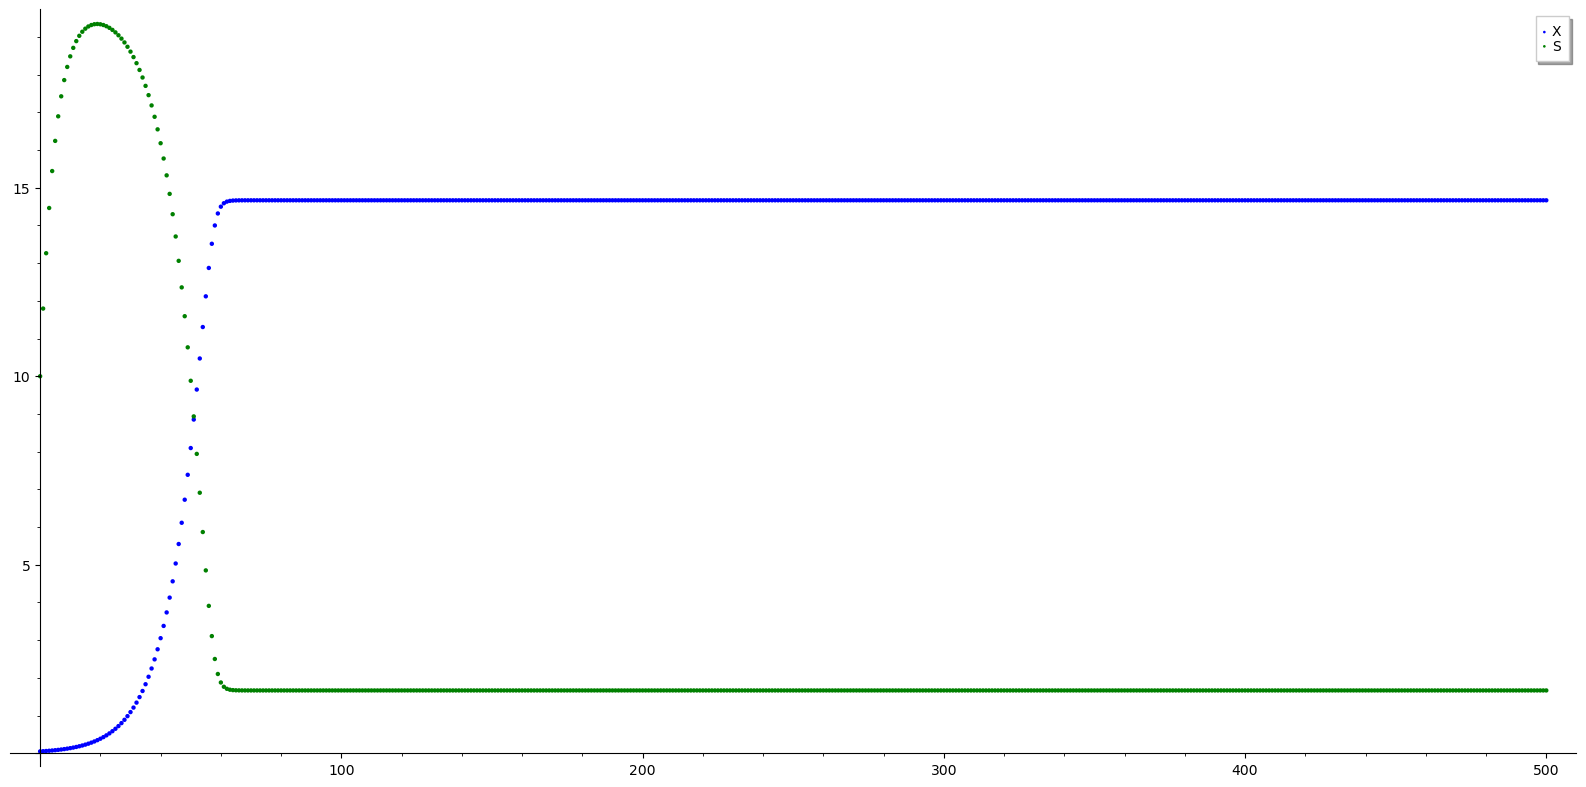

In [24]:
def plot_sol(sol):
    sim = get_sim_array(sol)
    P = list_plot(sim[:,0],legend_label='X')
    colors = ['blue','green']
    for i,var in enumerate(['S']):
        P += list_plot(sim[:,i+1],color=colors[i+1],legend_label=var)
   
    show(P, figsize=(16, 8))
plot_sol(T.solution)

In [25]:
mumax = 1.6   
Ks = 1.00     
Y = 0.8     
Sf = 20.0    
D = 1.00
#mu = mumax*S/(Ks+S)

Alterando o limite de concentraçao de saída do substrato, de 10 para 2:

In [26]:
T = ode_solver()
T.function = model
T.algorithm='rk8pd'
inits = [0.05, 2.0]
tspan = [0,100]
T.ode_solve(tspan, inits, num_points=500, params=[D, Sf, Y, mumax, Ks])

In [27]:
def get_sim_array(sol):
    sim = np.array([y for t,y in sol])
    return sim
get_sim_array(T.solution)

array([[ 0.05      ,  2.        ],
       [ 0.05248973,  5.24840496],
       [ 0.05672379,  7.90522943],
       ...,
       [14.66666667,  1.66666667],
       [14.66666667,  1.66666667],
       [14.66666667,  1.66666667]])

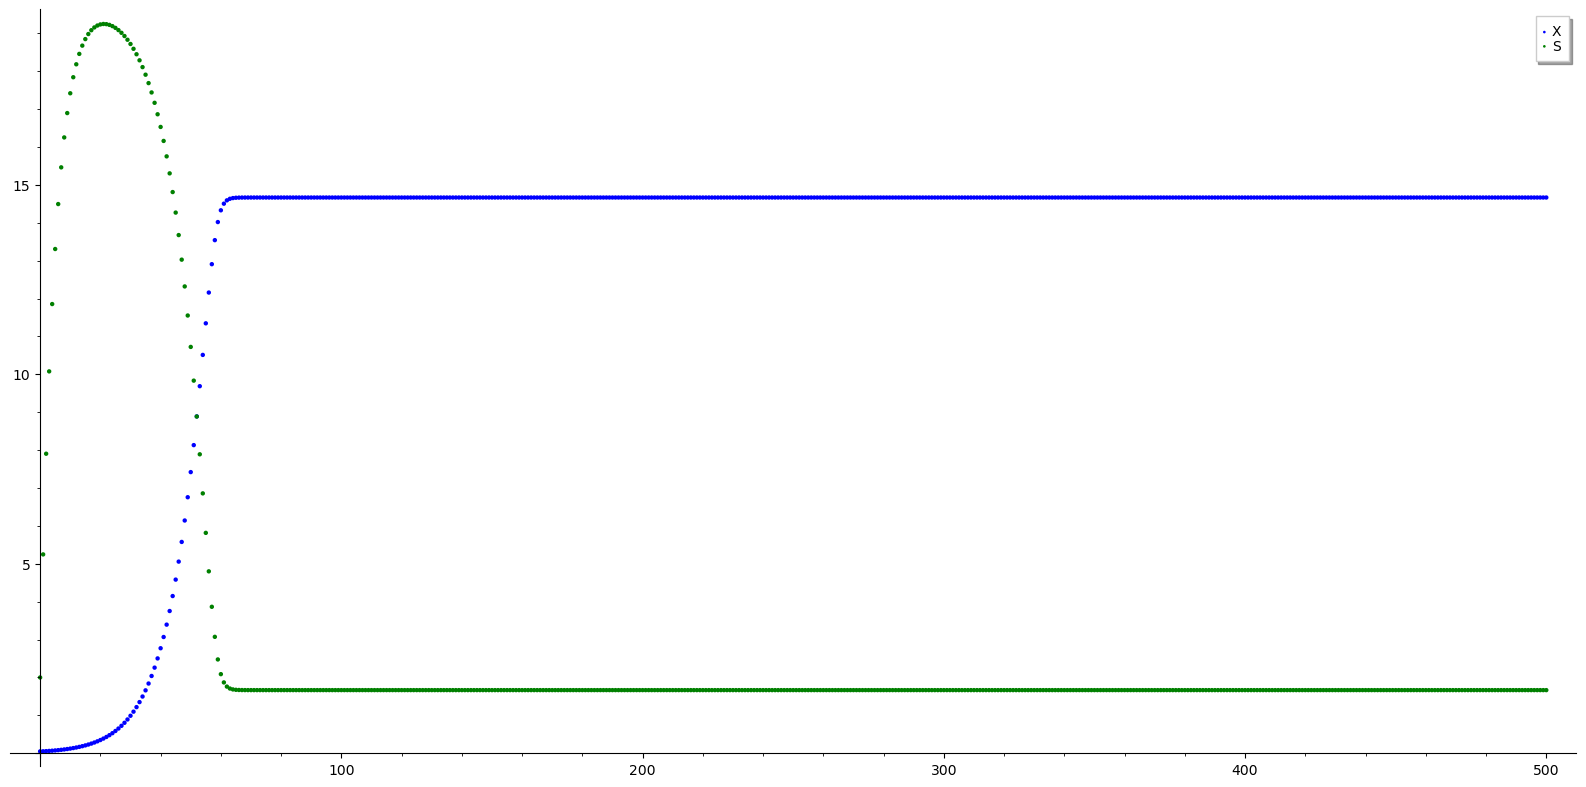

In [28]:
def plot_sol(sol):
    sim = get_sim_array(sol)
    P = list_plot(sim[:,0],legend_label='X')
    colors = ['blue','green']
    for i,var in enumerate(['S']):
        P += list_plot(sim[:,i+1],color=colors[i+1],legend_label=var)
   
    show(P, figsize=(16, 8))
plot_sol(T.solution)

Alterando o Coeficiente de Rendimento (Y) de 0.8 para 0.3:

In [70]:
mumax = 1.6   
Ks = 1.00     
Y = 0.3     
Sf = 20.0    
D = 1.00
#mu = mumax*S/(Ks+S)

In [71]:
S = Ks*D/(mumax-D)
print(S)

1.66666666666667


In [72]:
X = Y*(Sf- Ks*D/(mumax-D))
print(X)

5.50000000000000


In [73]:
mu = mumax*S/(Ks+S)
print(mu)

1.00000000000000


In [30]:
T = ode_solver()
T.function = model
T.algorithm='rk8pd'
inits = [0.05, 10.0]
tspan = [0,100]
T.ode_solve(tspan, inits, num_points=500, params=[D, Sf, Y, mumax, Ks])

In [31]:
def get_sim_array(sol):
    sim = np.array([y for t,y in sol])
    return sim
get_sim_array(T.solution)

array([[ 0.05      , 10.        ],
       [ 0.05487797, 11.76622101],
       [ 0.06042515, 13.20710238],
       ...,
       [ 5.5       ,  1.66666667],
       [ 5.5       ,  1.66666667],
       [ 5.5       ,  1.66666667]])

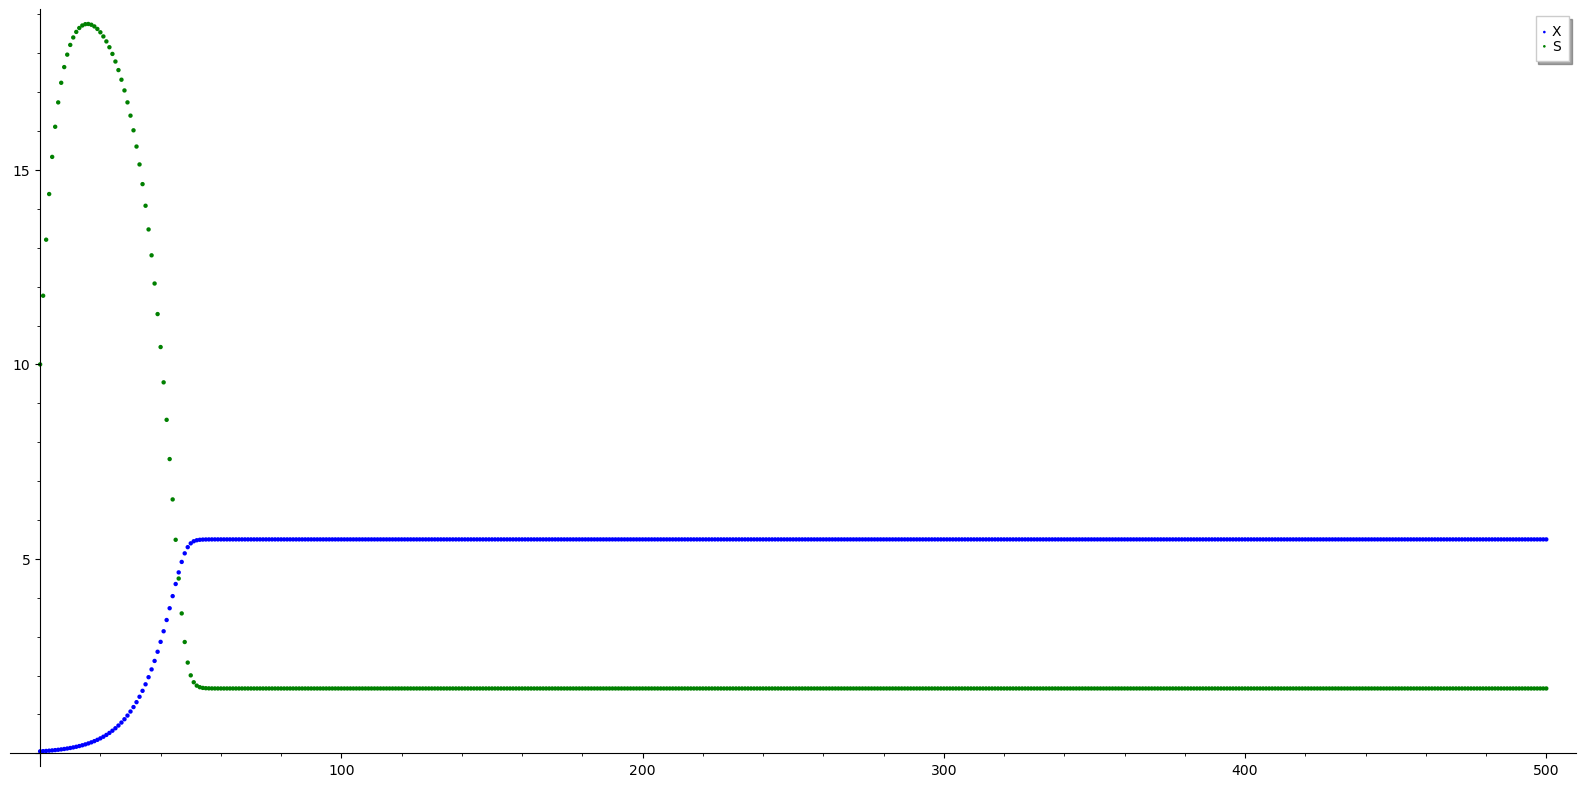

In [32]:
def plot_sol(sol):
    sim = get_sim_array(sol)
    P = list_plot(sim[:,0],legend_label='X')
    colors = ['blue','green']
    for i,var in enumerate(['S']):
        P += list_plot(sim[:,i+1],color=colors[i+1],legend_label=var)
   
    show(P, figsize=(16, 8))
plot_sol(T.solution)

In [3]:
mumax = 1.6   
Ks = 1.00     
Y = 1.3    
Sf = 20.0    
D = 1.00
#mu = mumax*S/(Ks+S)

In [4]:
S = Ks*D/(mumax-D)
print(S)

1.66666666666667


In [5]:
X = Y*(Sf- Ks*D/(mumax-D))
print(X)

23.8333333333333


In [6]:
mu = mumax*S/(Ks+S)
print(mu)

1.00000000000000


In [7]:
T = ode_solver()
T.function = model
T.algorithm='rk8pd'
inits = [0.05, 10.0]
tspan = [0,100]
T.ode_solve(tspan, inits, num_points=500, params=[D, Sf, Y, mumax, Ks])

In [8]:
def get_sim_array(sol):
    sim = np.array([y for t,y in sol])
    return sim
get_sim_array(T.solution)

array([[ 0.05      , 10.        ],
       [ 0.05488011, 11.80196664],
       [ 0.060433  , 13.27609415],
       ...,
       [23.83333333,  1.66666667],
       [23.83333333,  1.66666667],
       [23.83333333,  1.66666667]])

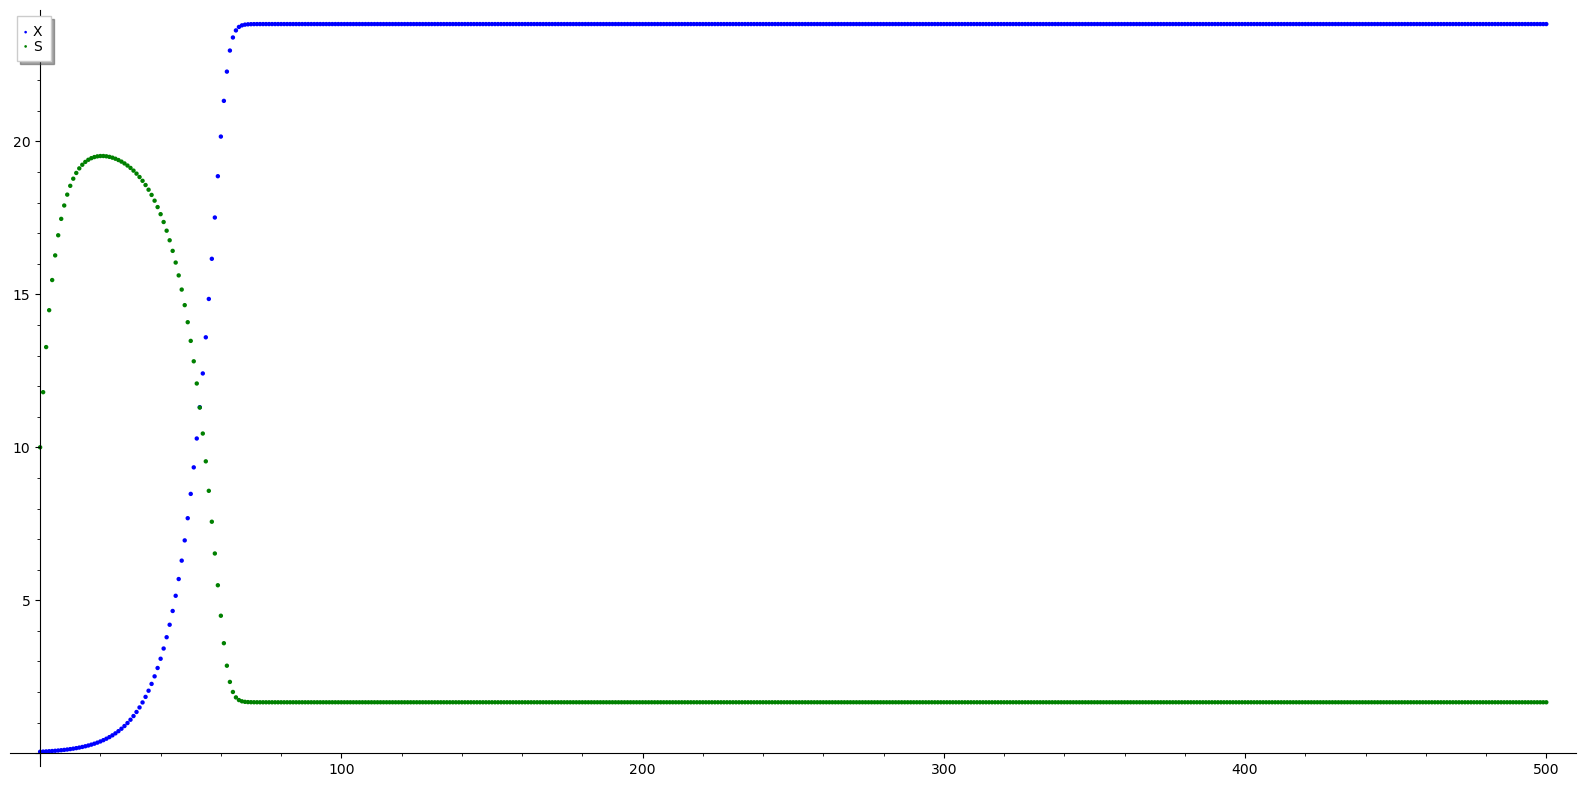

In [9]:
def plot_sol(sol):
    sim = get_sim_array(sol)
    P = list_plot(sim[:,0],legend_label='X')
    colors = ['blue','green']
    for i,var in enumerate(['S']):
        P += list_plot(sim[:,i+1],color=colors[i+1],legend_label=var)
   
    show(P, figsize=(16, 8))
plot_sol(T.solution)

Alterando o limite de concentraçao de saída do substrato, de 10 para 2:

In [33]:
T = ode_solver()
T.function = model
T.algorithm='rk8pd'
inits = [0.05, 2.0]
tspan = [0,100]
T.ode_solve(tspan, inits, num_points=500, params=[D, Sf, Y, mumax, Ks])

In [34]:
def get_sim_array(sol):
    sim = np.array([y for t,y in sol])
    return sim
get_sim_array(T.solution)

array([[0.05      , 2.        ],
       [0.05248187, 5.224362  ],
       [0.05670404, 7.85694573],
       ...,
       [5.5       , 1.66666667],
       [5.5       , 1.66666667],
       [5.5       , 1.66666667]])

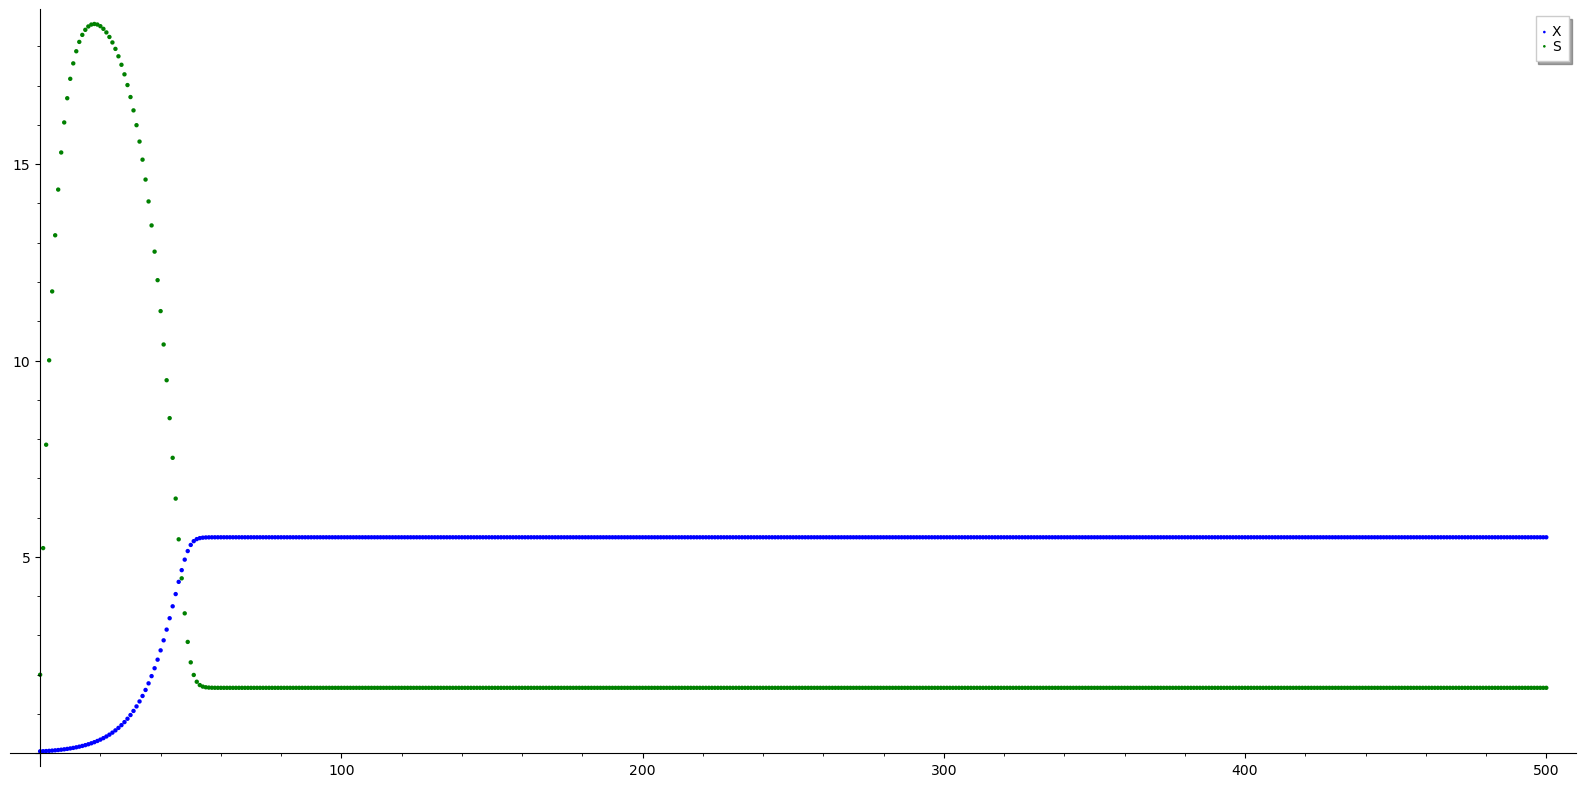

In [35]:
def plot_sol(sol):
    sim = get_sim_array(sol)
    P = list_plot(sim[:,0],legend_label='X')
    colors = ['blue','green']
    for i,var in enumerate(['S']):
        P += list_plot(sim[:,i+1],color=colors[i+1],legend_label=var)
   
    show(P, figsize=(16, 8))
plot_sol(T.solution)

Duplicando a Máxima Taxa de Crescimento Específica (mumax):

In [74]:
mumax = 3.2
Ks = 1.00     
Y = 0.8     
Sf = 20.0    
D = 1.00
#mu = mumax*S/(Ks+S)

In [75]:
S = Ks*D/(mumax-D)
print(S)

0.454545454545455


In [76]:
X = Y*(Sf- Ks*D/(mumax-D))
print(X)

15.6363636363636


In [77]:
mu = mumax*S/(Ks+S)
print(mu)

1.00000000000000


In [37]:
T = ode_solver()
T.function = model
T.algorithm='rk8pd'
inits = [0.05, 10.0]
tspan = [0,100]
T.ode_solve(tspan, inits, num_points=500, params=[D, Sf, Y, mumax, Ks])

In [38]:
def get_sim_array(sol):
    sim = np.array([y for t,y in sol])
    return sim
get_sim_array(T.solution)

array([[ 0.05      , 10.        ],
       [ 0.07356861, 11.77190238],
       [ 0.10894173, 13.20251737],
       ...,
       [15.63636364,  0.45454545],
       [15.63636364,  0.45454545],
       [15.63636364,  0.45454545]])

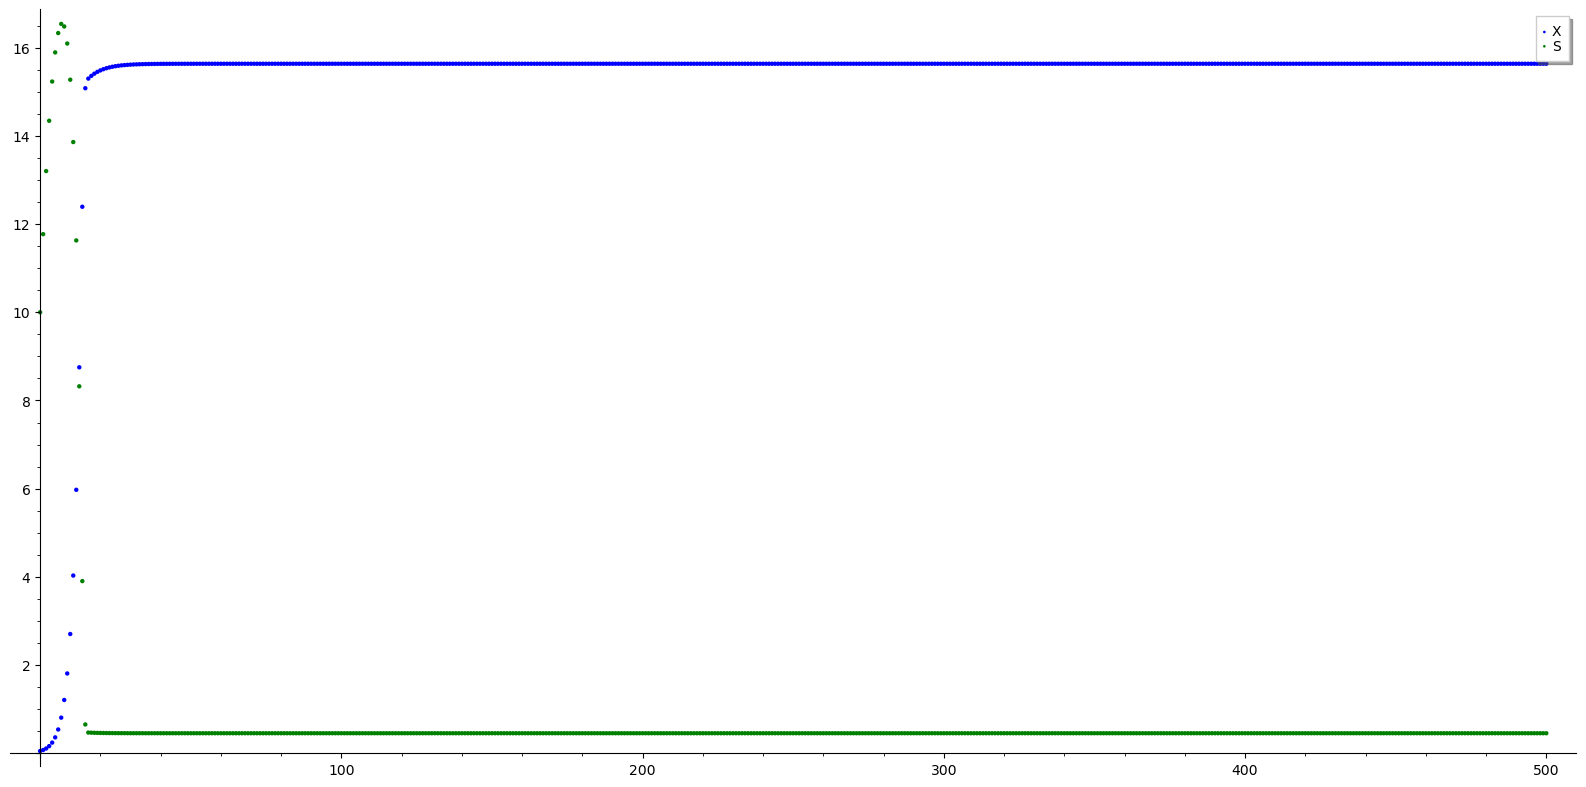

In [39]:
def plot_sol(sol):
    sim = get_sim_array(sol)
    P = list_plot(sim[:,0],legend_label='X')
    colors = ['blue','green']
    for i,var in enumerate(['S']):
        P += list_plot(sim[:,i+1],color=colors[i+1],legend_label=var)
   
    show(P, figsize=(16, 8))
plot_sol(T.solution)

In [79]:
mumax = 3.2
Ks = 1.00     
Y = 0.3     
Sf = 20.0    
D = 1.00
#mu = mumax*S/(Ks+S)

In [80]:
S = Ks*D/(mumax-D)
print(S)

0.454545454545455


In [81]:
X = Y*(Sf- Ks*D/(mumax-D))
print(X)

5.86363636363636


In [82]:
mu = mumax*S/(Ks+S)
print(mu)

1.00000000000000


In [58]:
T = ode_solver()
T.function = model
T.algorithm='rk8pd'
inits = [0.05, 10.0]
tspan = [0,100]
T.ode_solve(tspan, inits, num_points=500, params=[D, Sf, Y, mumax, Ks])

In [59]:
def get_sim_array(sol):
    sim = np.array([y for t,y in sol])
    return sim
get_sim_array(T.solution)

array([[ 0.05      , 10.        ],
       [ 0.07355826, 11.70395341],
       [ 0.10888445, 13.04557137],
       ...,
       [ 5.86363636,  0.45454545],
       [ 5.86363636,  0.45454545],
       [ 5.86363636,  0.45454545]])

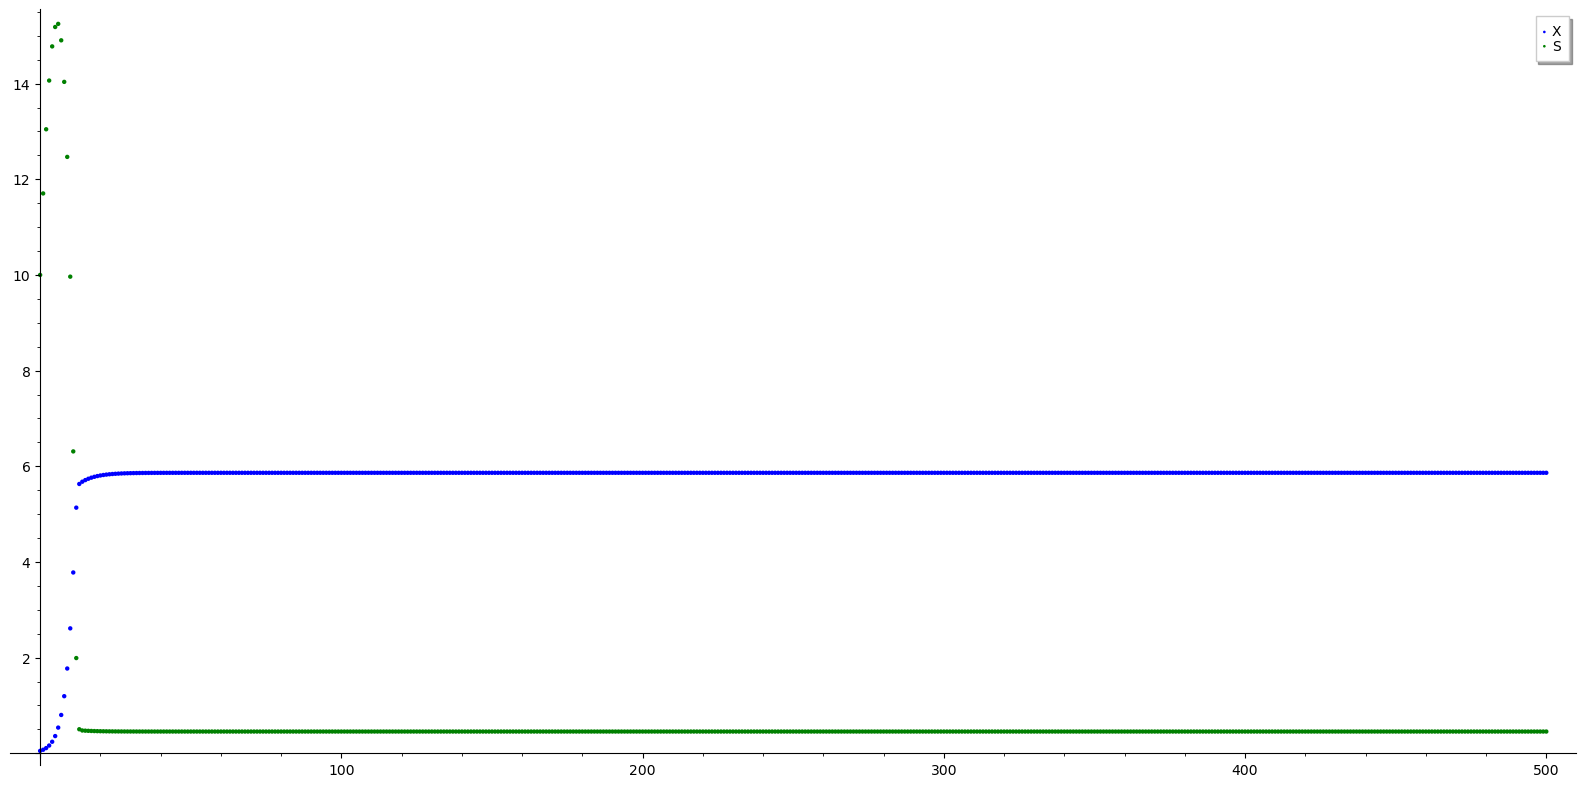

In [60]:
def plot_sol(sol):
    sim = get_sim_array(sol)
    P = list_plot(sim[:,0],legend_label='X')
    colors = ['blue','green']
    for i,var in enumerate(['S']):
        P += list_plot(sim[:,i+1],color=colors[i+1],legend_label=var)
   
    show(P, figsize=(16, 8))
plot_sol(T.solution)

Dividindo mumax pela metade:

In [83]:
mumax = 0.8
Ks = 1.00     
Y = 0.8    
Sf = 20.0    
D = 1.00
#mu = mumax*S/(Ks+S)

In [85]:
S = Ks*D/(mumax-D)
print(S)

-5.00000000000000


In [86]:
X = Y*(Sf- Ks*D/(mumax-D))
print(X)

20.0000000000000


In [87]:
mu = mumax*S/(Ks+S)
print(mu)

1.00000000000000


In [62]:
T = ode_solver()
T.function = model
T.algorithm='rk8pd'
inits = [0.05, 10.0]
tspan = [0,100]
T.ode_solve(tspan, inits, num_points=500, params=[D, Sf, Y, mumax, Ks])

In [63]:
def get_sim_array(sol):
    sim = np.array([y for t,y in sol])
    return sim
get_sim_array(T.solution)

array([[5.00000000e-02, 1.00000000e+01],
       [4.73983944e-02, 1.18046151e+01],
       [4.50054819e-02, 1.32824377e+01],
       ...,
       [2.44971388e-12, 2.00000000e+01],
       [2.33579473e-12, 2.00000000e+01],
       [2.22717316e-12, 2.00000000e+01]])

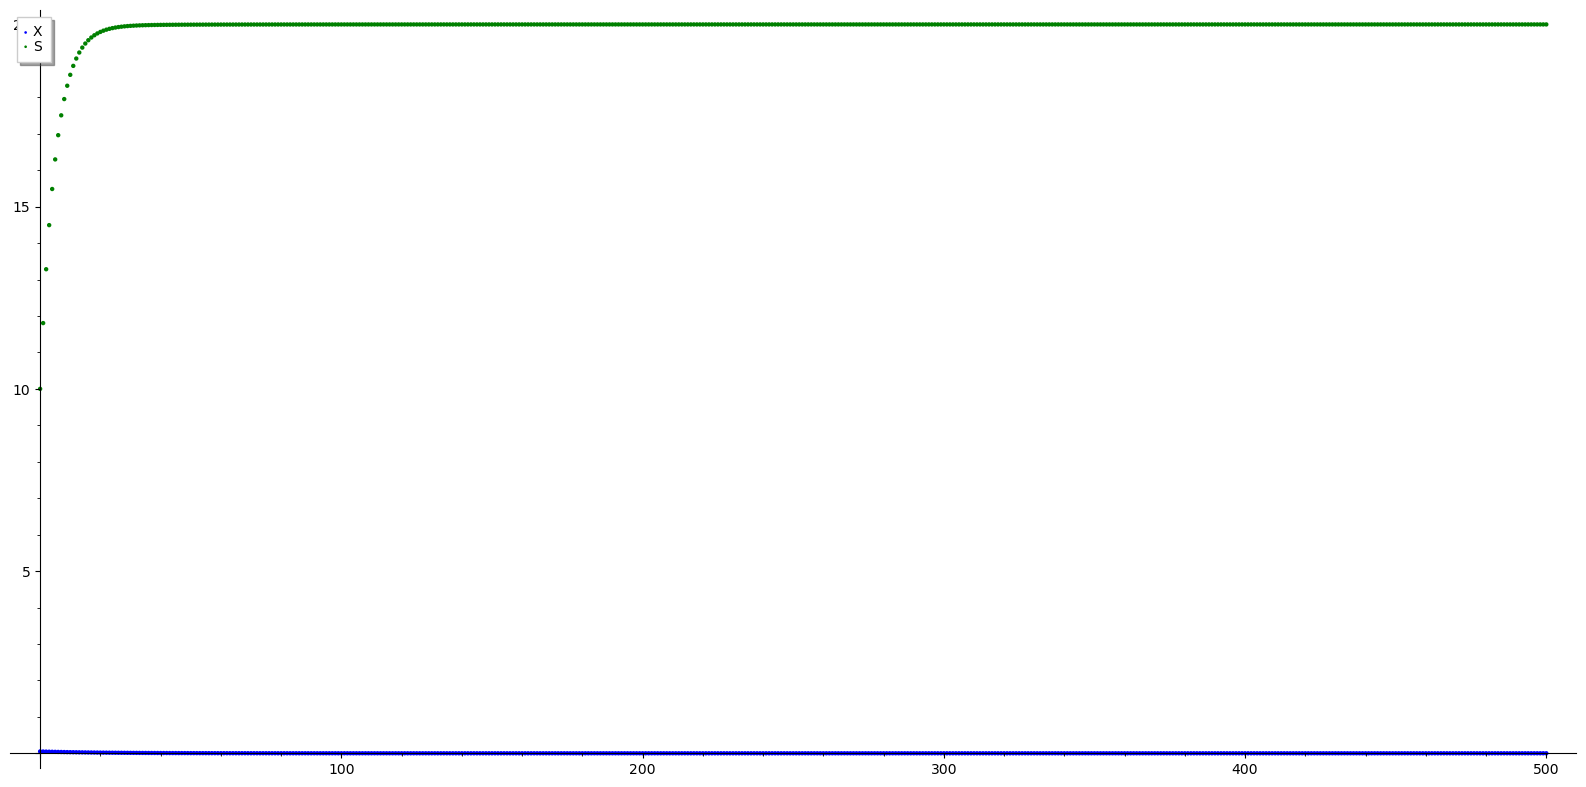

In [64]:
def plot_sol(sol):
    sim = get_sim_array(sol)
    P = list_plot(sim[:,0],legend_label='X')
    colors = ['blue','green']
    for i,var in enumerate(['S']):
        P += list_plot(sim[:,i+1],color=colors[i+1],legend_label=var)
   
    show(P, figsize=(16, 8))
plot_sol(T.solution)

In [16]:
mumax = 0.8
Ks = 1.00     
Y = 0.3    
Sf = 20.0    
D = 1.00
#mu = mumax*S/(Ks+S)

In [17]:
S = Ks*D/(mumax-D)
print(S)

-5.00000000000000


In [18]:
X = Y*(Sf- (Ks*D/(mumax-D)))
print(X)

7.50000000000000


In [19]:
mu = mumax*S/(Ks+S)
print(mu)

1.00000000000000


In [23]:
T = ode_solver()
T.function = model
T.algorithm='rk8pd'
inits = [0.05, 10.0]
tspan = [0,100]
T.ode_solve(tspan, inits, num_points=500, params=[D, Sf, Y, mumax, Ks])

In [24]:
def get_sim_array(sol):
    sim = np.array([y for t,y in sol])
    return sim
get_sim_array(T.solution)

array([[5.00000000e-02, 1.00000000e+01],
       [4.73980372e-02, 1.17911541e+01],
       [4.50044068e-02, 1.32585049e+01],
       ...,
       [2.44808418e-12, 2.00000000e+01],
       [2.33424081e-12, 2.00000000e+01],
       [2.22569150e-12, 2.00000000e+01]])

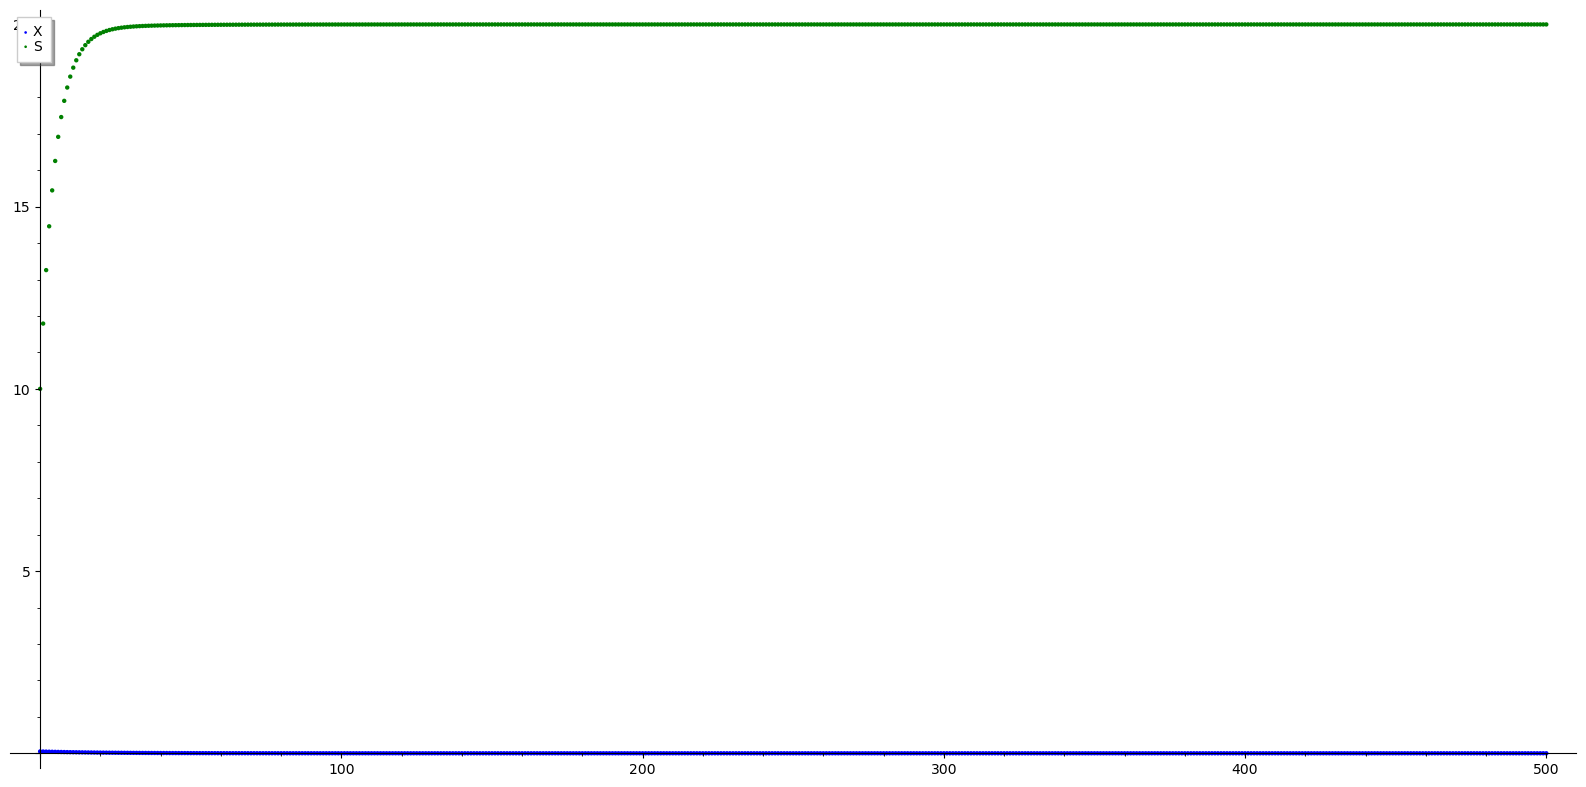

In [25]:
def plot_sol(sol):
    sim = get_sim_array(sol)
    P = list_plot(sim[:,0],legend_label='X')
    colors = ['blue','green']
    for i,var in enumerate(['S']):
        P += list_plot(sim[:,i+1],color=colors[i+1],legend_label=var)
   
    show(P, figsize=(16, 8))
plot_sol(T.solution)

Diminuindo mumax:

In [46]:
mumax = 1.0
Ks = 1.00     
Y = 0.3    
Sf = 20.0    
D = 1.00
#mu = mumax*S/(Ks+S)

In [47]:
S = Ks*D/(mumax-D)
print(S)

+infinity


In [27]:
mu = mumax*S/(Ks+S)
print(mu)

1.25000000000000


In [28]:
T = ode_solver()
T.function = model
T.algorithm='rk8pd'
inits = [0.05, 10.0]
tspan = [0,100]
T.ode_solve(tspan, inits, num_points=500, params=[D, Sf, Y, mumax, Ks])

In [29]:
def get_sim_array(sol):
    sim = np.array([y for t,y in sol])
    return sim
get_sim_array(T.solution)

array([[5.00000000e-02, 1.00000000e+01],
       [4.91666857e-02, 1.17852586e+01],
       [4.84451076e-02, 1.32470359e+01],
       ...,
       [4.19328423e-04, 1.99986022e+01],
       [4.15353514e-04, 1.99986155e+01],
       [4.11416287e-04, 1.99986286e+01]])

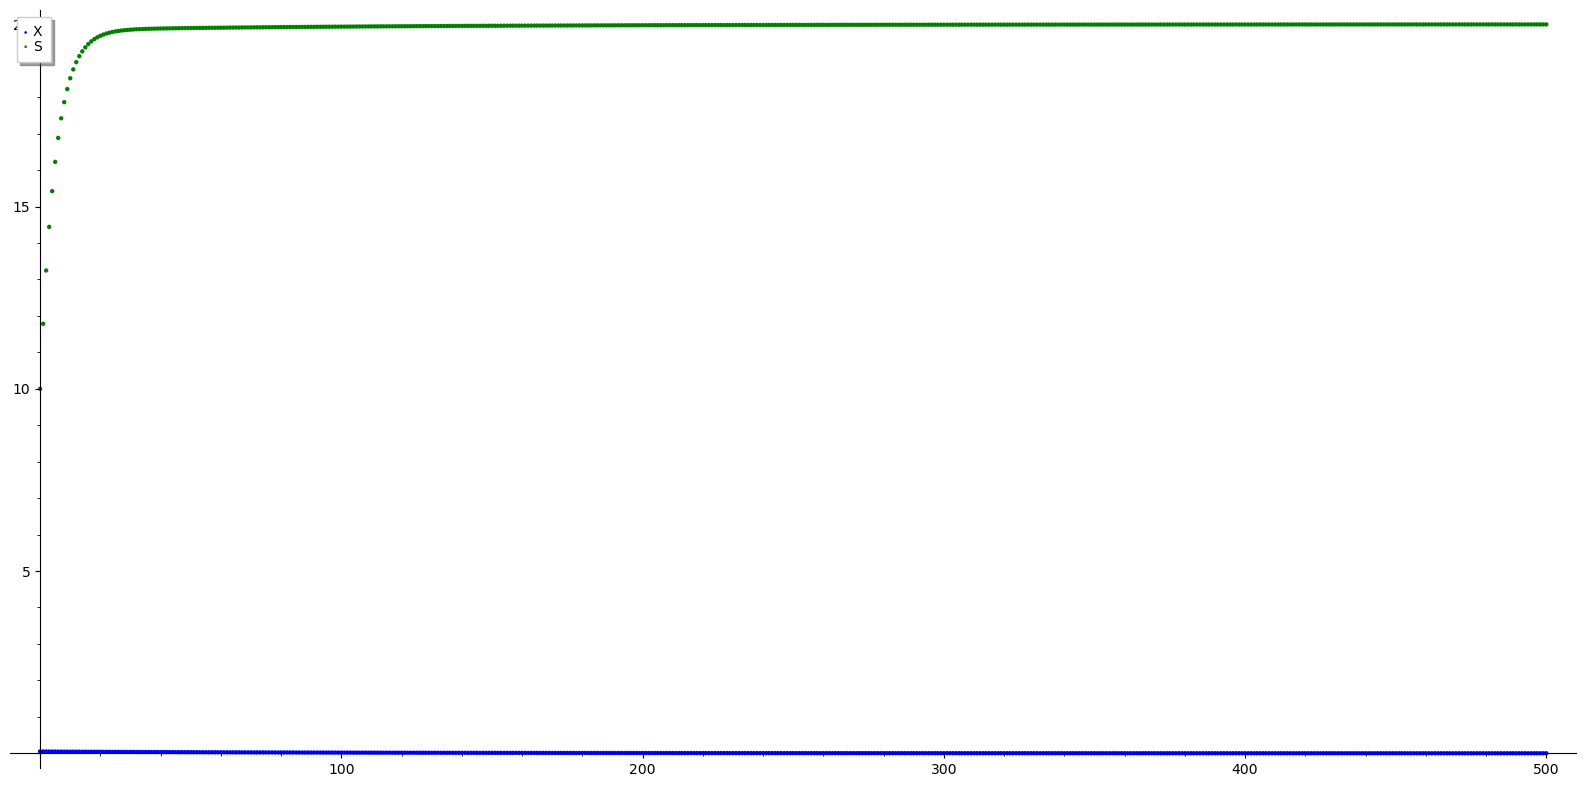

In [30]:
def plot_sol(sol):
    sim = get_sim_array(sol)
    P = list_plot(sim[:,0],legend_label='X')
    colors = ['blue','green']
    for i,var in enumerate(['S']):
        P += list_plot(sim[:,i+1],color=colors[i+1],legend_label=var)
   
    show(P, figsize=(16, 8))
plot_sol(T.solution)

In [10]:
mumax = 1.2
Ks = 1.00     
Y = 0.3    
Sf = 20.0    
D = 1.00
#mu = mumax*S/(Ks+S)

In [11]:
S = Ks*D/(mumax-D)
print(S)

5.00000000000000


In [12]:
mu = mumax*S/(Ks+S)
print(mu)

1.00000000000000


In [13]:
T = ode_solver()
T.function = model
T.algorithm='rk8pd'
inits = [0.05, 10.0]
tspan = [0,100]
T.ode_solve(tspan, inits, num_points=500, params=[D, Sf, Y, mumax, Ks])

In [14]:
def get_sim_array(sol):
    sim = np.array([y for t,y in sol])
    return sim
get_sim_array(T.solution)

array([[ 0.05      , 10.        ],
       [ 0.05100124, 11.77914345],
       [ 0.05214854, 13.23469109],
       ...,
       [ 4.5       ,  5.        ],
       [ 4.5       ,  5.        ],
       [ 4.5       ,  5.        ]])

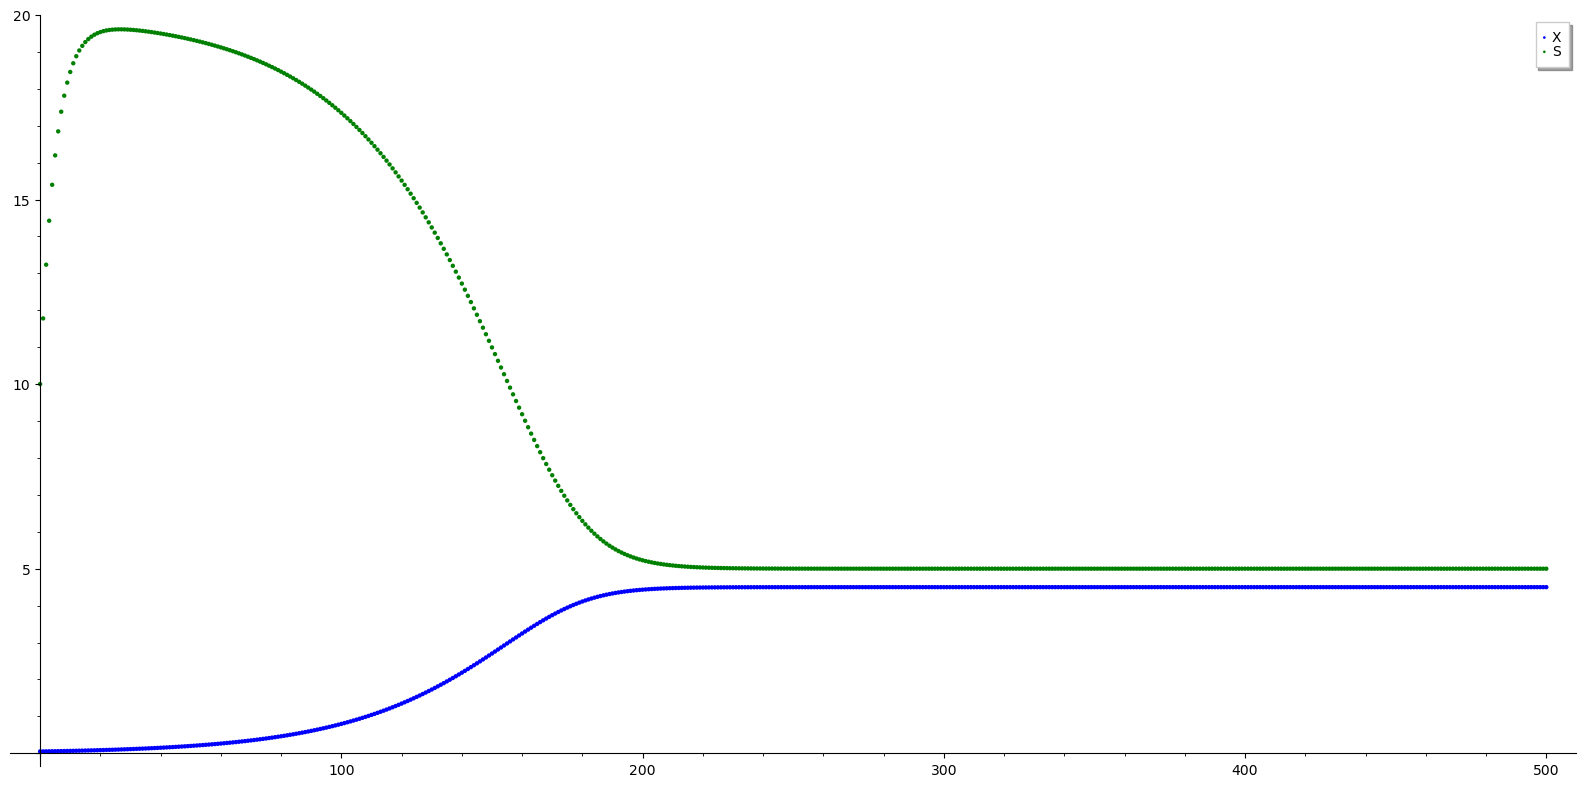

In [15]:
def plot_sol(sol):
    sim = get_sim_array(sol)
    P = list_plot(sim[:,0],legend_label='X')
    colors = ['blue','green']
    for i,var in enumerate(['S']):
        P += list_plot(sim[:,i+1],color=colors[i+1],legend_label=var)
   
    show(P, figsize=(16, 8))
plot_sol(T.solution)

In [16]:
mumax = 1.2
Ks = 1.00     
Y = 0.8    
Sf = 20.0    
D = 1.00
#mu = mumax*S/(Ks+S)

In [17]:
S = Ks*D/(mumax-D)
print(S)

5.00000000000000


In [18]:
mu = mumax*S/(Ks+S)
print(mu)

1.00000000000000


In [19]:
T = ode_solver()
T.function = model
T.algorithm='rk8pd'
inits = [0.05, 10.0]
tspan = [0,100]
T.ode_solve(tspan, inits, num_points=500, params=[D, Sf, Y, mumax, Ks])

In [20]:
def get_sim_array(sol):
    sim = np.array([y for t,y in sol])
    return sim
get_sim_array(T.solution)

array([[ 0.05      , 10.        ],
       [ 0.05100213, 11.80011048],
       [ 0.05215148, 13.27350519],
       ...,
       [12.        ,  5.        ],
       [12.        ,  5.        ],
       [12.        ,  5.        ]])

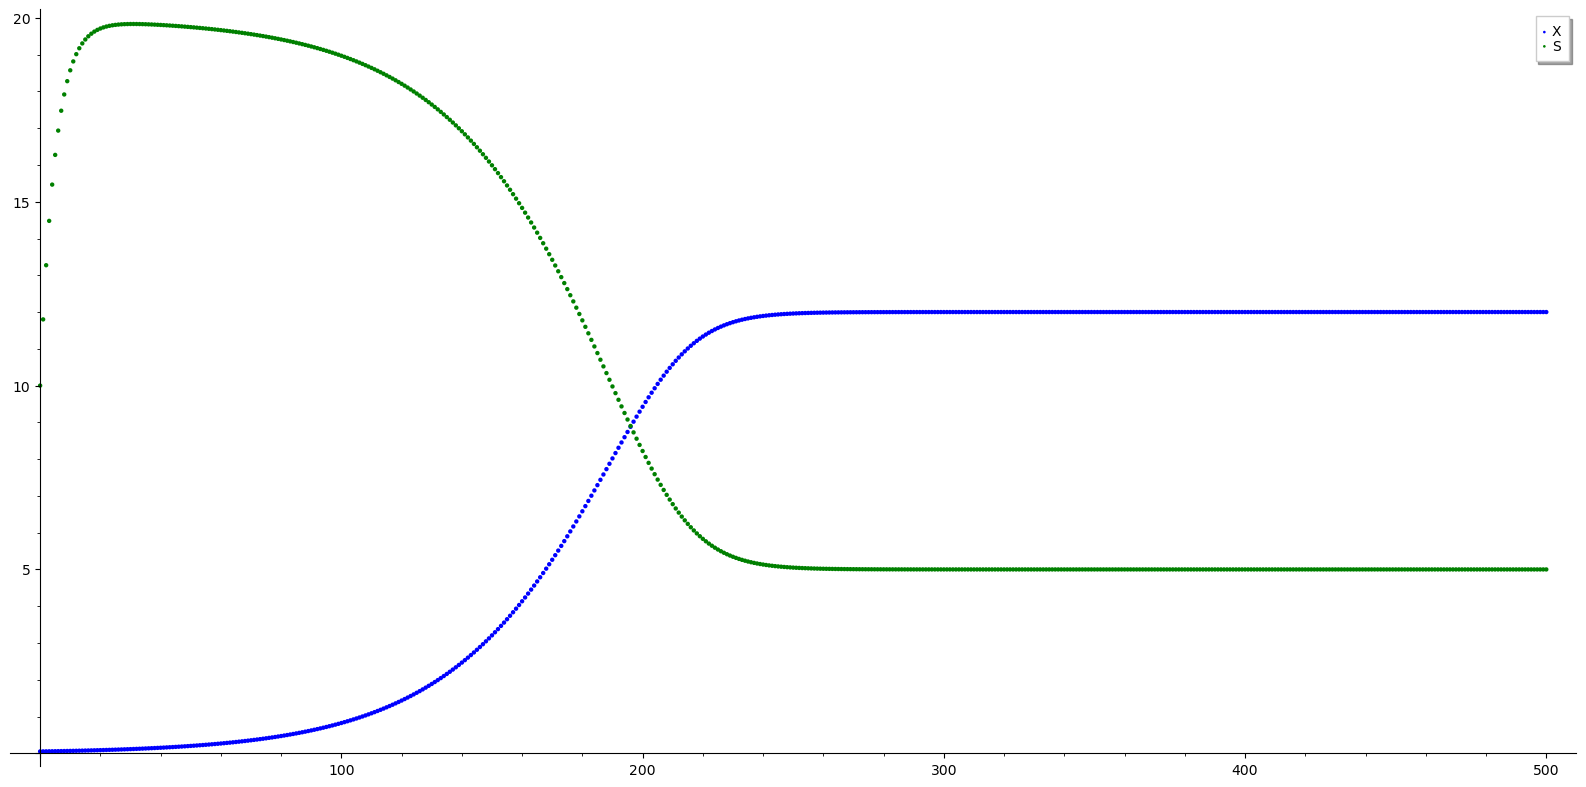

In [21]:
def plot_sol(sol):
    sim = get_sim_array(sol)
    P = list_plot(sim[:,0],legend_label='X')
    colors = ['blue','green']
    for i,var in enumerate(['S']):
        P += list_plot(sim[:,i+1],color=colors[i+1],legend_label=var)
   
    show(P, figsize=(16, 8))
plot_sol(T.solution)

In [42]:
mumax = 1.5
Ks = 1.00     
Y = 0.3    
Sf = 20.0    
D = 1.00
#mu = mumax*S/(Ks+S)

In [43]:
S = Ks*D/(mumax-D)
print(S)

2.00000000000000


In [34]:
mu = mumax*S/(Ks+S)
print(mu)

1.87500000000000


In [61]:
mumax = 1.6
Ks = 1.00     
Y = 0.3    
Sf = 20.0    
D = 1.00
#mu = mumax*S/(Ks+S)

In [62]:
S = Ks*D/(mumax-D)
print(S)

1.66666666666667


In [63]:
mu = mumax*S/(Ks+S)
print(mu)

1.00000000000000


In [64]:
T = ode_solver()
T.function = model
T.algorithm='rk8pd'
inits = [0.05, 10.0]
tspan = [0,100]
T.ode_solve(tspan, inits, num_points=500, params=[D, Sf, Y, mumax, Ks])

In [65]:
def get_sim_array(sol):
    sim = np.array([y for t,y in sol])
    return sim
get_sim_array(T.solution)

array([[ 0.05      , 10.        ],
       [ 0.05487797, 11.76622101],
       [ 0.06042515, 13.20710238],
       ...,
       [ 5.5       ,  1.66666667],
       [ 5.5       ,  1.66666667],
       [ 5.5       ,  1.66666667]])

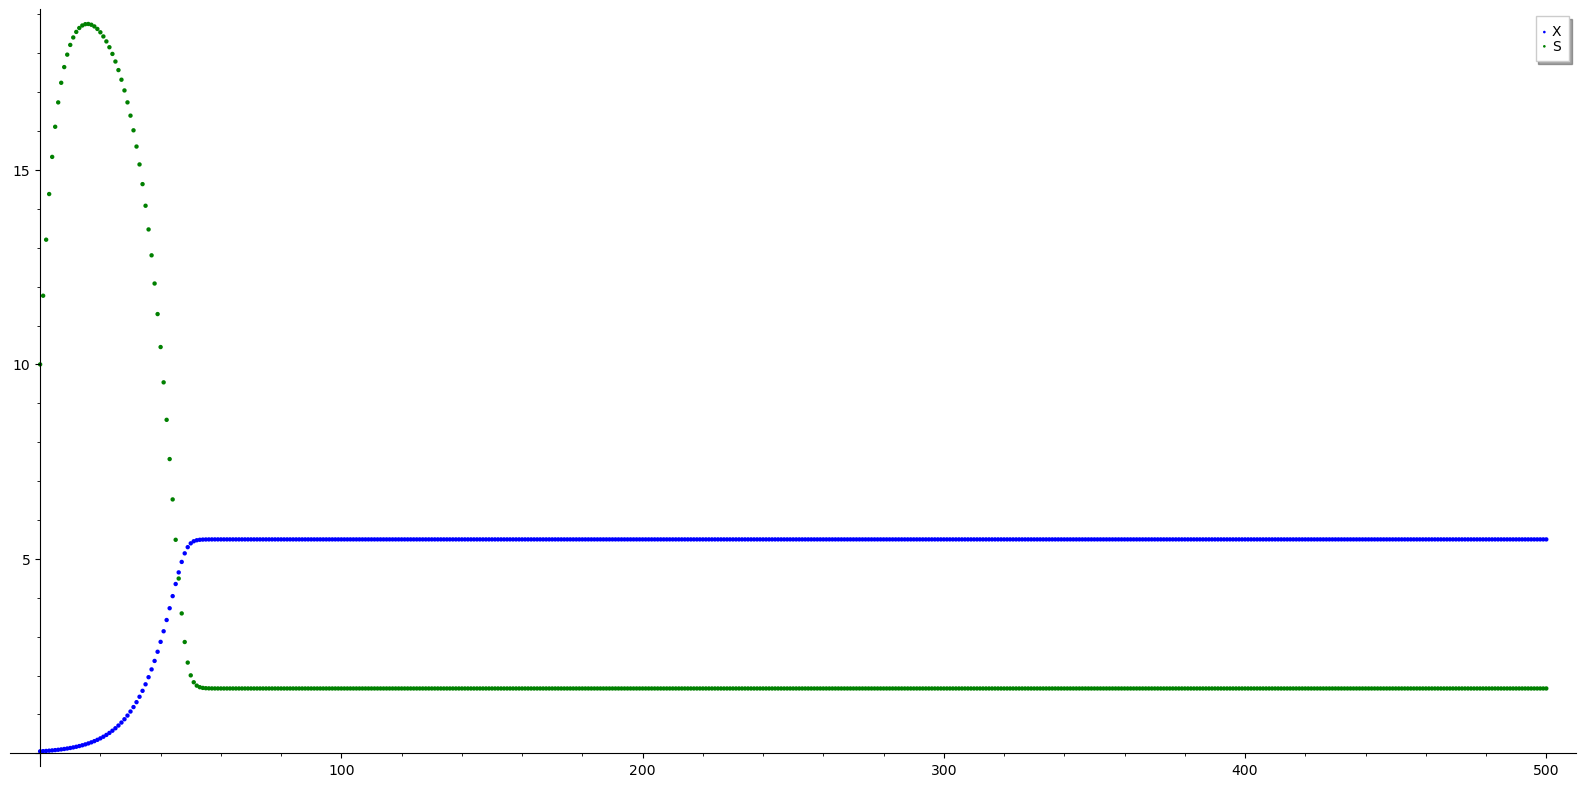

In [66]:
def plot_sol(sol):
    sim = get_sim_array(sol)
    P = list_plot(sim[:,0],legend_label='X')
    colors = ['blue','green']
    for i,var in enumerate(['S']):
        P += list_plot(sim[:,i+1],color=colors[i+1],legend_label=var)
   
    show(P, figsize=(16, 8))
plot_sol(T.solution)

Duplicando a concentração de massa celular inicial (X):

In [69]:
mumax = 1.6   
Ks = 1.00     
Y = 0.8     
Sf = 20.0    
D = 1.00
#mu = mumax*S/(Ks+S)

In [68]:
mu = mumax*S/(Ks+S)
print(mu)

1.00000000000000


In [70]:
S = Ks*D/(mumax-D)
print(S)

1.66666666666667


In [41]:
T = ode_solver()
T.function = model
T.algorithm='rk8pd'
inits = [0.1, 10.0]
tspan = [0,100]
T.ode_solve(tspan, inits, num_points=500, params=[D, Sf, Y, mumax, Ks])

In [42]:
def get_sim_array(sol):
    sim = np.array([y for t,y in sol])
    return sim
get_sim_array(T.solution)

array([[ 0.1       , 10.        ],
       [ 0.10975734, 11.77783714],
       [ 0.12085542, 13.22952027],
       ...,
       [14.66666667,  1.66666667],
       [14.66666667,  1.66666667],
       [14.66666667,  1.66666667]])

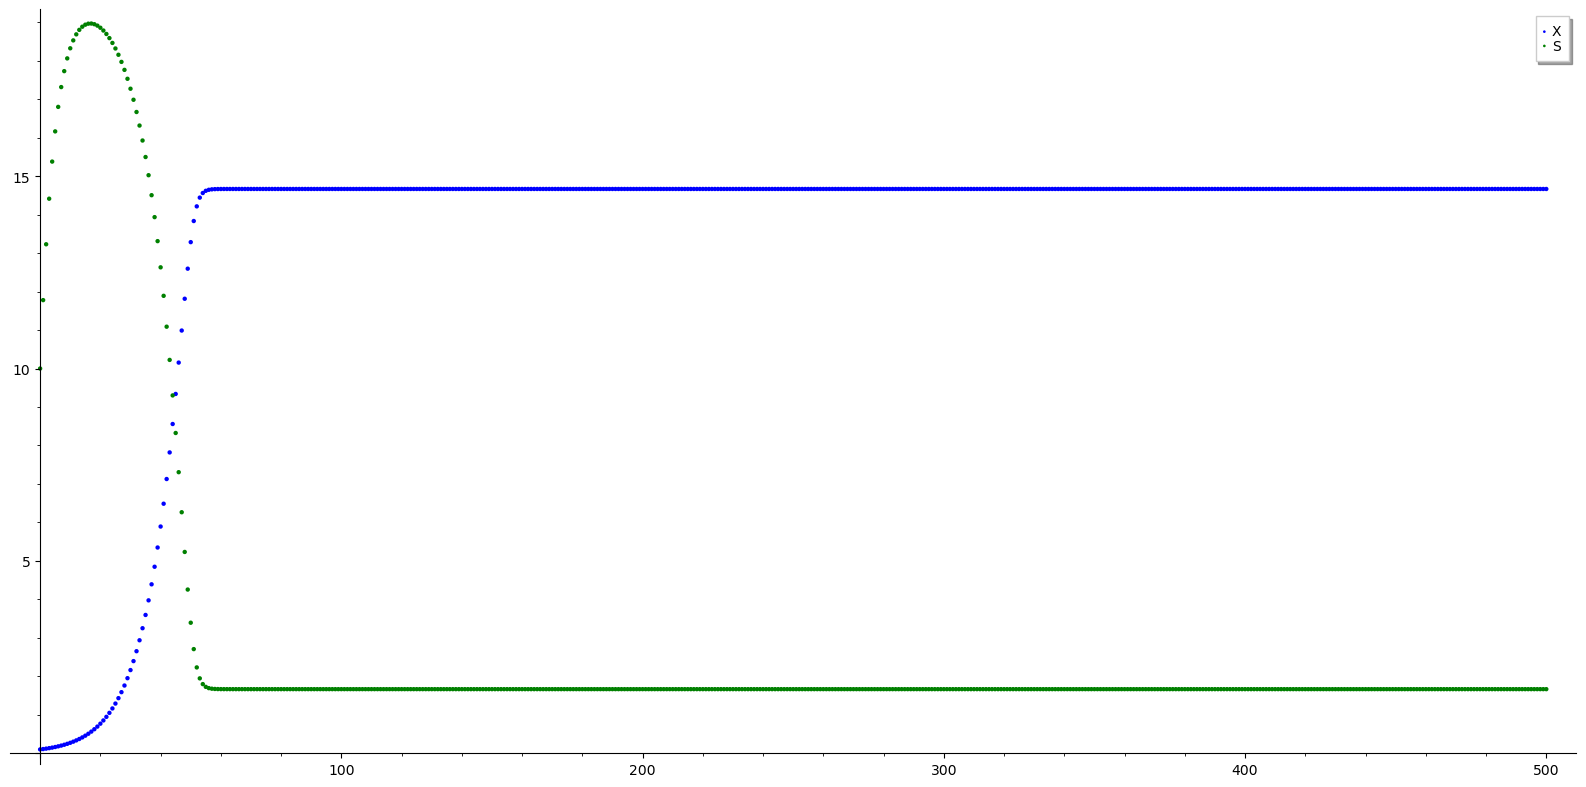

In [43]:
def plot_sol(sol):
    sim = get_sim_array(sol)
    P = list_plot(sim[:,0],legend_label='X')
    colors = ['blue','green']
    for i,var in enumerate(['S']):
        P += list_plot(sim[:,i+1],color=colors[i+1],legend_label=var)
   
    show(P, figsize=(16, 8))
plot_sol(T.solution)

Dividindo a concentração de massa celular inicial (X) pela metade:

In [44]:
T = ode_solver()
T.function = model
T.algorithm='rk8pd'
inits = [0.025, 10.0]
tspan = [0,100]
T.ode_solve(tspan, inits, num_points=500, params=[D, Sf, Y, mumax, Ks])

In [45]:
def get_sim_array(sol):
    sim = np.array([y for t,y in sol])
    return sim
get_sim_array(T.solution)

array([[ 0.025     , 10.        ],
       [ 0.02744012, 11.80397766],
       [ 0.03021672, 13.27997614],
       ...,
       [14.66666667,  1.66666667],
       [14.66666667,  1.66666667],
       [14.66666667,  1.66666667]])

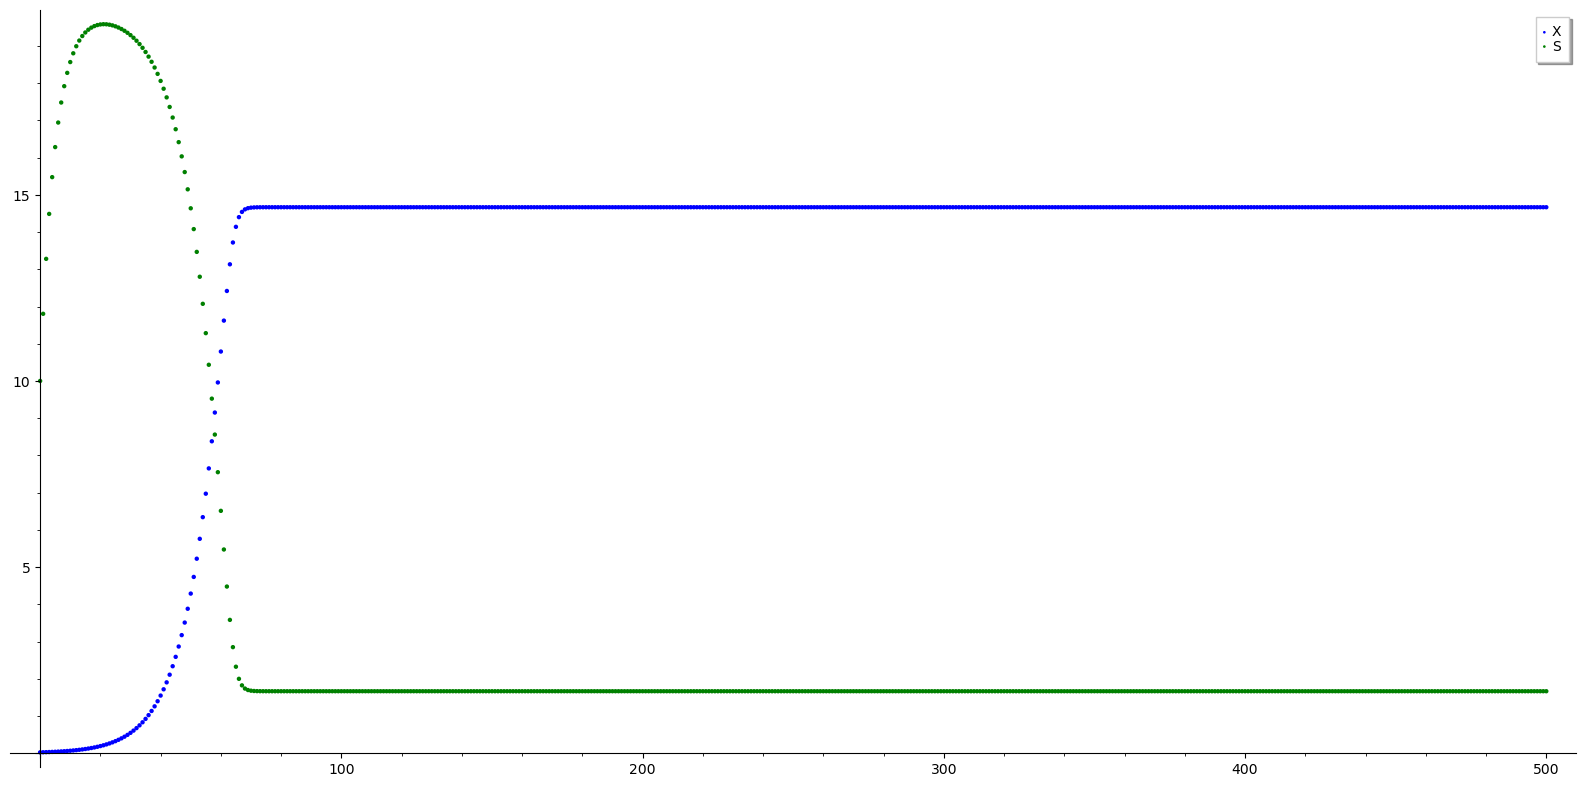

In [46]:
def plot_sol(sol):
    sim = get_sim_array(sol)
    P = list_plot(sim[:,0],legend_label='X')
    colors = ['blue','green']
    for i,var in enumerate(['S']):
        P += list_plot(sim[:,i+1],color=colors[i+1],legend_label=var)
   
    show(P, figsize=(16, 8))
plot_sol(T.solution)

Duplicando o limite de concentração de saída do substrato (S):

In [71]:
T = ode_solver()
T.function = model
T.algorithm='rk8pd'
inits = [0.05, 20.0]
tspan = [0,100]
T.ode_solve(tspan, inits, num_points=500, params=[D, Sf, Y, mumax, Ks])

In [72]:
mu = mumax*S/(Ks+S)
print(mu)

1.00000000000000


In [73]:
def get_sim_array(sol):
    sim = np.array([y for t,y in sol])
    return sim
get_sim_array(T.solution)

array([[ 0.05      , 20.        ],
       [ 0.05552194, 19.98176825],
       [ 0.06165292, 19.96482885],
       ...,
       [14.66666667,  1.66666667],
       [14.66666667,  1.66666667],
       [14.66666667,  1.66666667]])

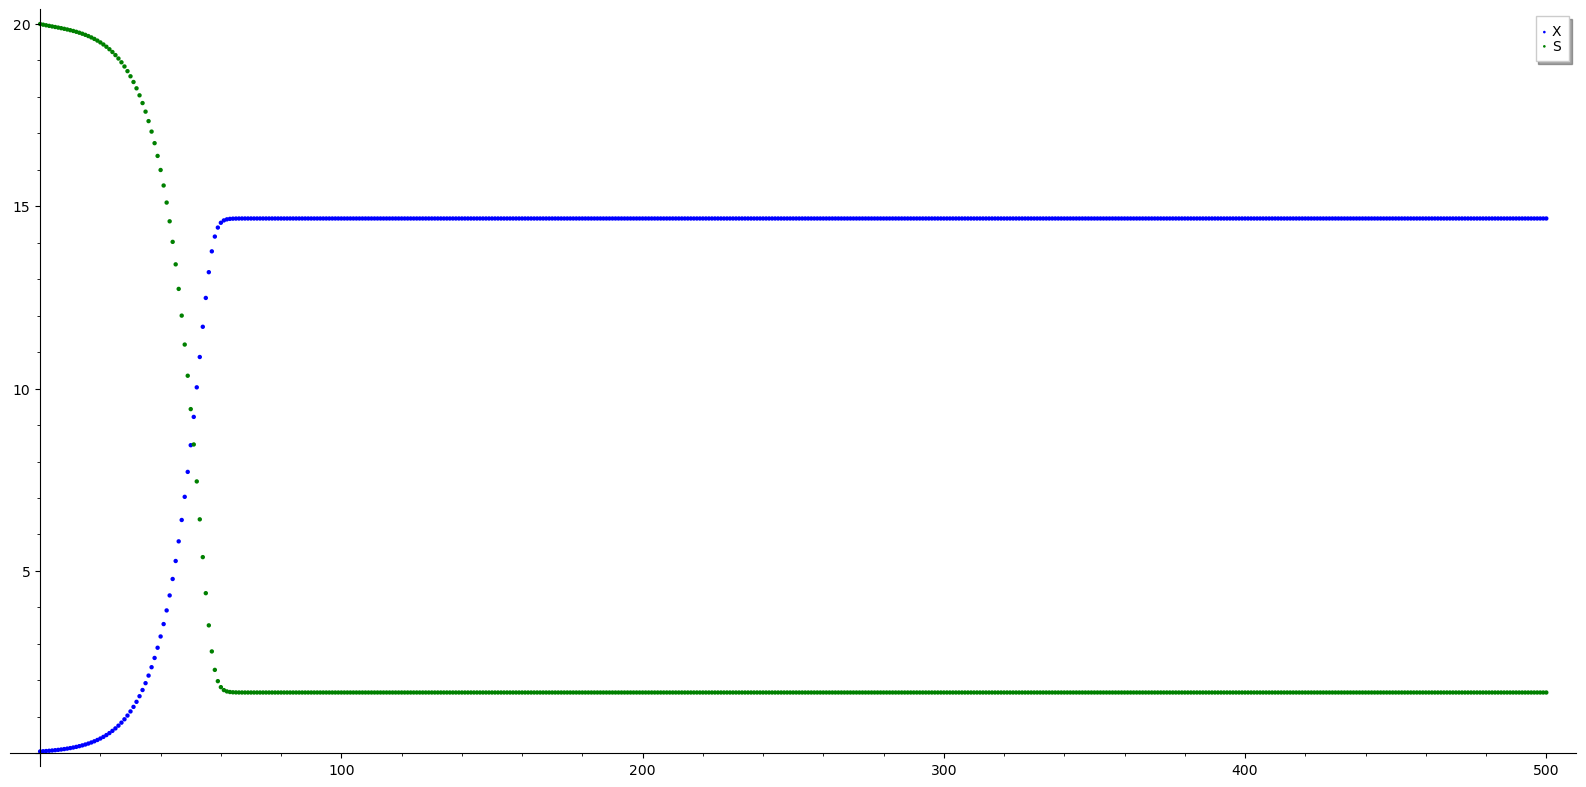

In [74]:
def plot_sol(sol):
    sim = get_sim_array(sol)
    P = list_plot(sim[:,0],legend_label='X')
    colors = ['blue','green']
    for i,var in enumerate(['S']):
        P += list_plot(sim[:,i+1],color=colors[i+1],legend_label=var)
   
    show(P, figsize=(16, 8))
plot_sol(T.solution)

Dividindo o limite de concentração de saída do substrato (S) pela metade:

In [75]:
T = ode_solver()
T.function = model
T.algorithm='rk8pd'
inits = [0.05, 5.0]
tspan = [0,100]
T.ode_solve(tspan, inits, num_points=500, params=[D, Sf, Y, mumax, Ks])

In [76]:
mu = mumax*S/(Ks+S)
print(mu)

1.00000000000000


In [51]:
def get_sim_array(sol):
    sim = np.array([y for t,y in sol])
    return sim
get_sim_array(T.solution)

array([[ 0.05      ,  5.        ],
       [ 0.0539612 ,  7.70275788],
       [ 0.0588872 ,  9.91348532],
       ...,
       [14.66666667,  1.66666667],
       [14.66666667,  1.66666667],
       [14.66666667,  1.66666667]])

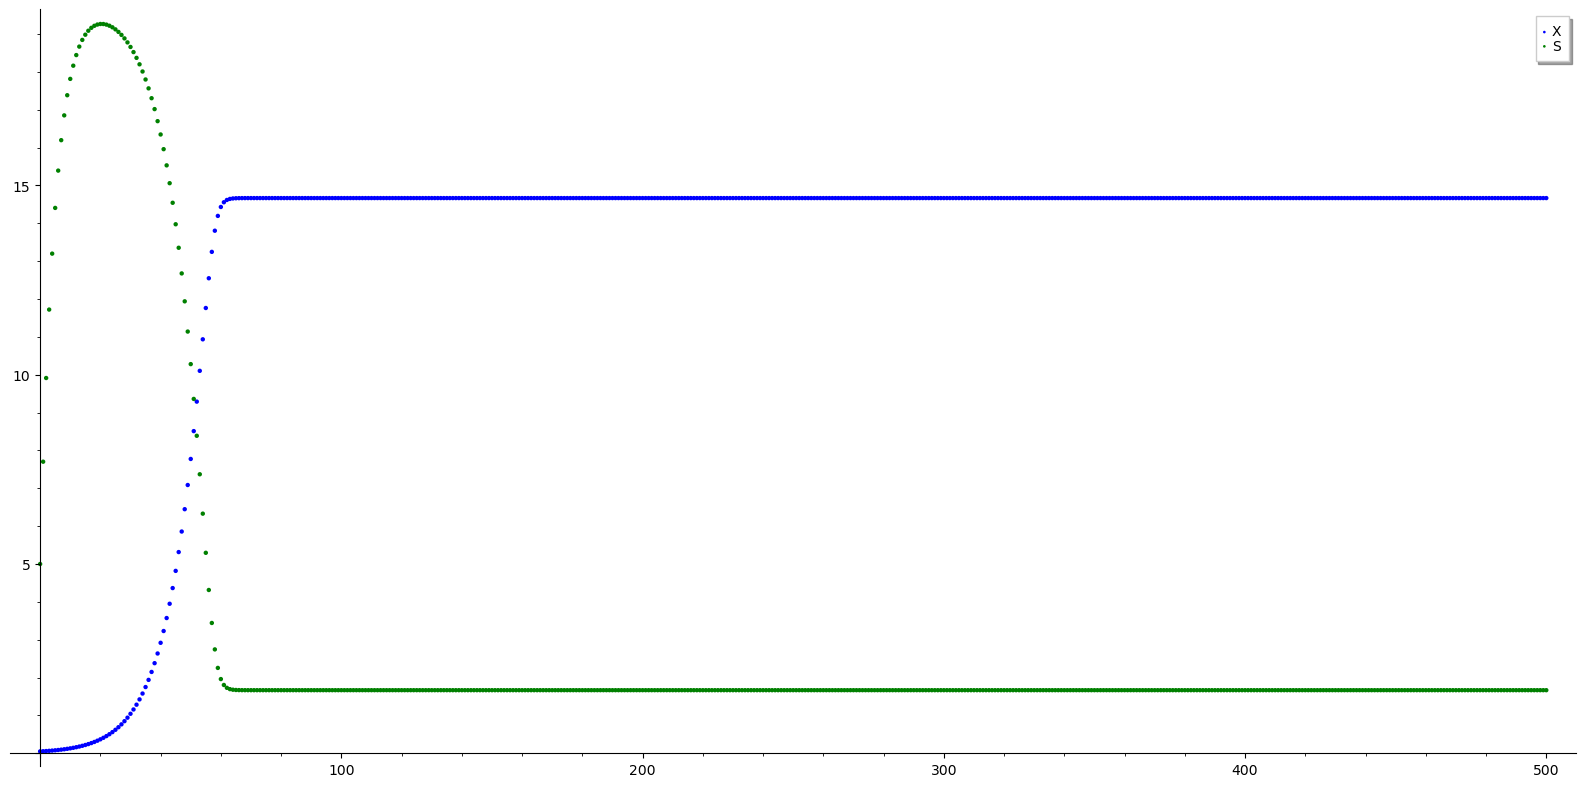

In [52]:
def plot_sol(sol):
    sim = get_sim_array(sol)
    P = list_plot(sim[:,0],legend_label='X')
    colors = ['blue','green']
    for i,var in enumerate(['S']):
        P += list_plot(sim[:,i+1],color=colors[i+1],legend_label=var)
   
    show(P, figsize=(16, 8))
plot_sol(T.solution)

In [58]:
mumax = 1.6   
Ks = 1.00     
Y = 0.8     
Sf = 20.0    
D = 1.00
#mu = mumax*S/(Ks+S)

In [59]:
S = Ks*D/(mumax-D)
print(S)

1.66666666666667


In [60]:
mu = mumax*S/(Ks+S)
print(mu)

1.00000000000000


In [79]:
T = ode_solver()
T.function = model
T.algorithm='rk8pd'
inits = [0.5, 10.0]
tspan = [0,100]
T.ode_solve(tspan, inits, num_points=500, params=[D, Sf, Y, mumax, Ks])

In [80]:
mu = mumax*S/(Ks+S)
print(mu)

1.00000000000000


In [104]:
def get_sim_array(sol):
    sim = np.array([y for t,y in sol])
    return sim
get_sim_array(T.solution)

array([[ 0.5       , 10.        ],
       [ 0.54870261, 11.63852093],
       [ 0.60396676, 12.96079112],
       ...,
       [14.66666667,  1.66666667],
       [14.66666667,  1.66666667],
       [14.66666667,  1.66666667]])

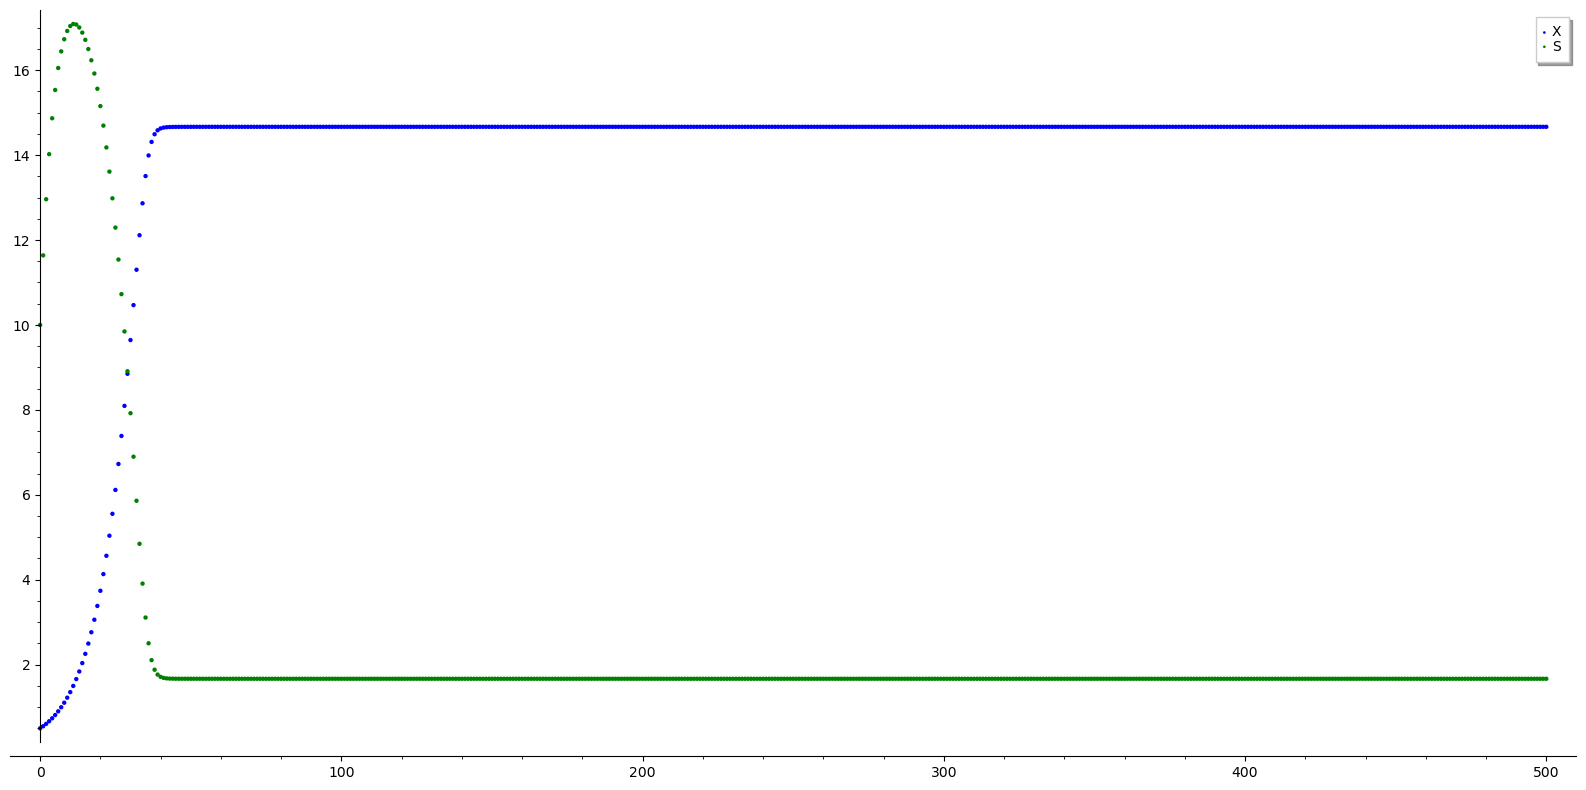

In [105]:
def plot_sol(sol):
    sim = get_sim_array(sol)
    P = list_plot(sim[:,0],legend_label='X')
    colors = ['blue','green']
    for i,var in enumerate(['S']):
        P += list_plot(sim[:,i+1],color=colors[i+1],legend_label=var)
   
    show(P, figsize=(16, 8))
plot_sol(T.solution)

In [81]:
T = ode_solver()
T.function = model
T.algorithm='rk8pd'
inits = [5.0, 10.0]
tspan = [0,100]
T.ode_solve(tspan, inits, num_points=500, params=[D, Sf, Y, mumax, Ks])

In [82]:
mu = mumax*S/(Ks+S)
print(mu)

1.00000000000000


In [108]:
def get_sim_array(sol):
    sim = np.array([y for t,y in sol])
    return sim
get_sim_array(T.solution)

array([[ 5.        , 10.        ],
       [ 5.47668076, 10.08390872],
       [ 5.99868176,  9.98794763],
       ...,
       [14.66666667,  1.66666667],
       [14.66666667,  1.66666667],
       [14.66666667,  1.66666667]])

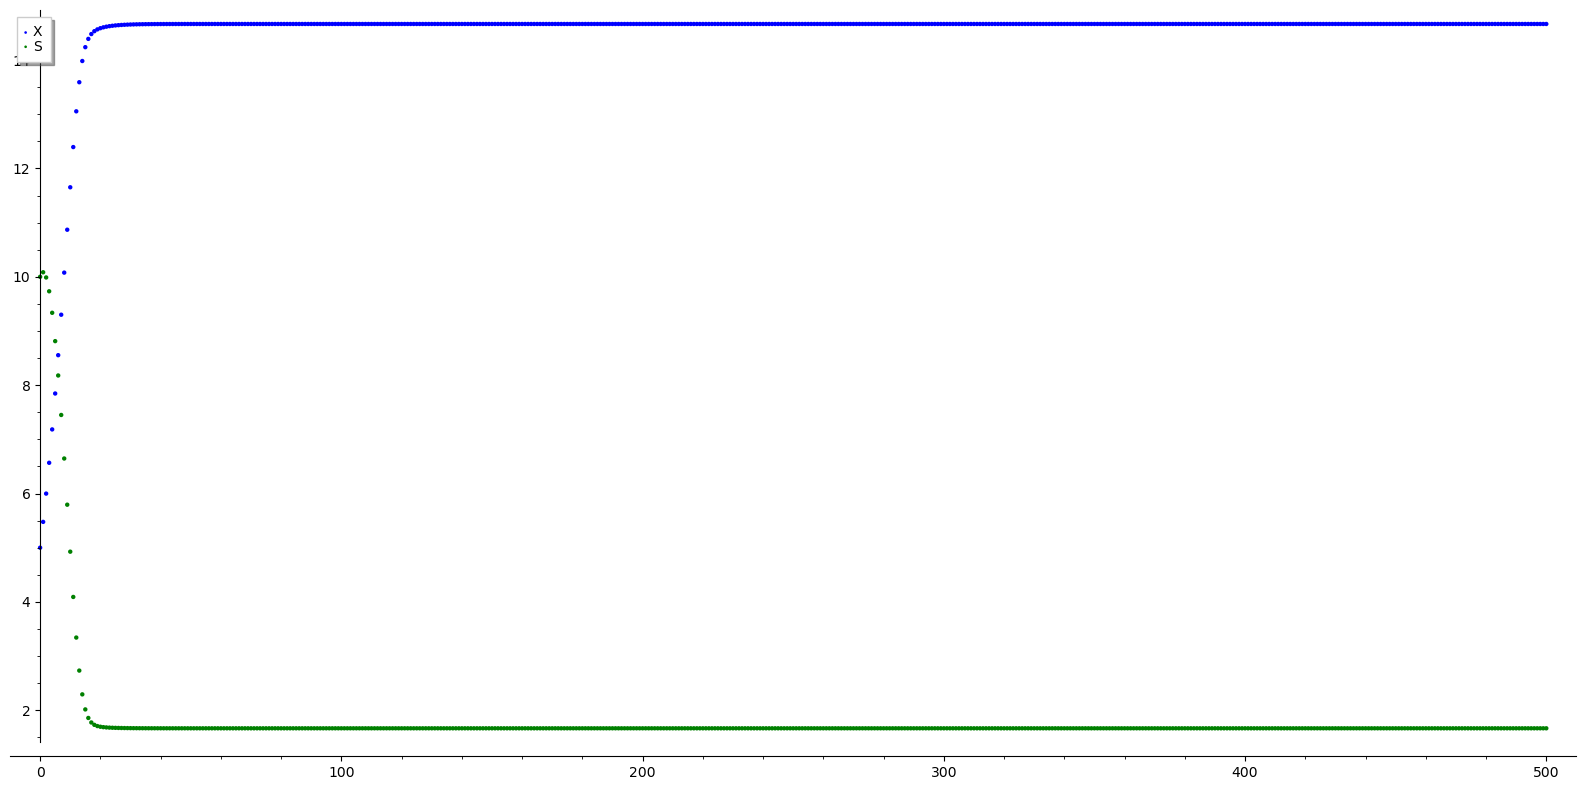

In [109]:
def plot_sol(sol):
    sim = get_sim_array(sol)
    P = list_plot(sim[:,0],legend_label='X')
    colors = ['blue','green']
    for i,var in enumerate(['S']):
        P += list_plot(sim[:,i+1],color=colors[i+1],legend_label=var)
   
    show(P, figsize=(16, 8))
plot_sol(T.solution)

In [81]:
mumax = 1.6   
Ks = 1.00     
Y = 0.8     
Sf = 20.0    
D = 2.00
#mu = mumax*S/(Ks+S)

In [86]:
S = Ks*D/(mumax-D)
print(mumax-D)
print(Ks*D)
print(S)

-0.400000000000000
2.00000000000000
-5.00000000000000


In [83]:
X = Y*(Sf- (Ks*D/(mumax-D)))
print(X)

20.0000000000000


In [84]:
mu = mumax*S/(Ks+S)
print(mu)

2.00000000000000


In [155]:
T = ode_solver()
T.function = model
T.algorithm='rk8pd'
inits = [0.05, 10.0]
tspan = [0,100]
T.ode_solve(tspan, inits, num_points=500, params=[D, Sf, Y, mumax, Ks])

In [156]:
def get_sim_array(sol):
    sim = np.array([y for t,y in sol])
    return sim
get_sim_array(T.solution)

array([[5.00000000e-02, 1.00000000e+01],
       [4.50054819e-02, 1.32824377e+01],
       [4.06925686e-02, 1.54839277e+01],
       ...,
       [1.23064257e-22, 2.00000000e+01],
       [1.11884663e-22, 2.00000000e+01],
       [1.01720662e-22, 2.00000000e+01]])

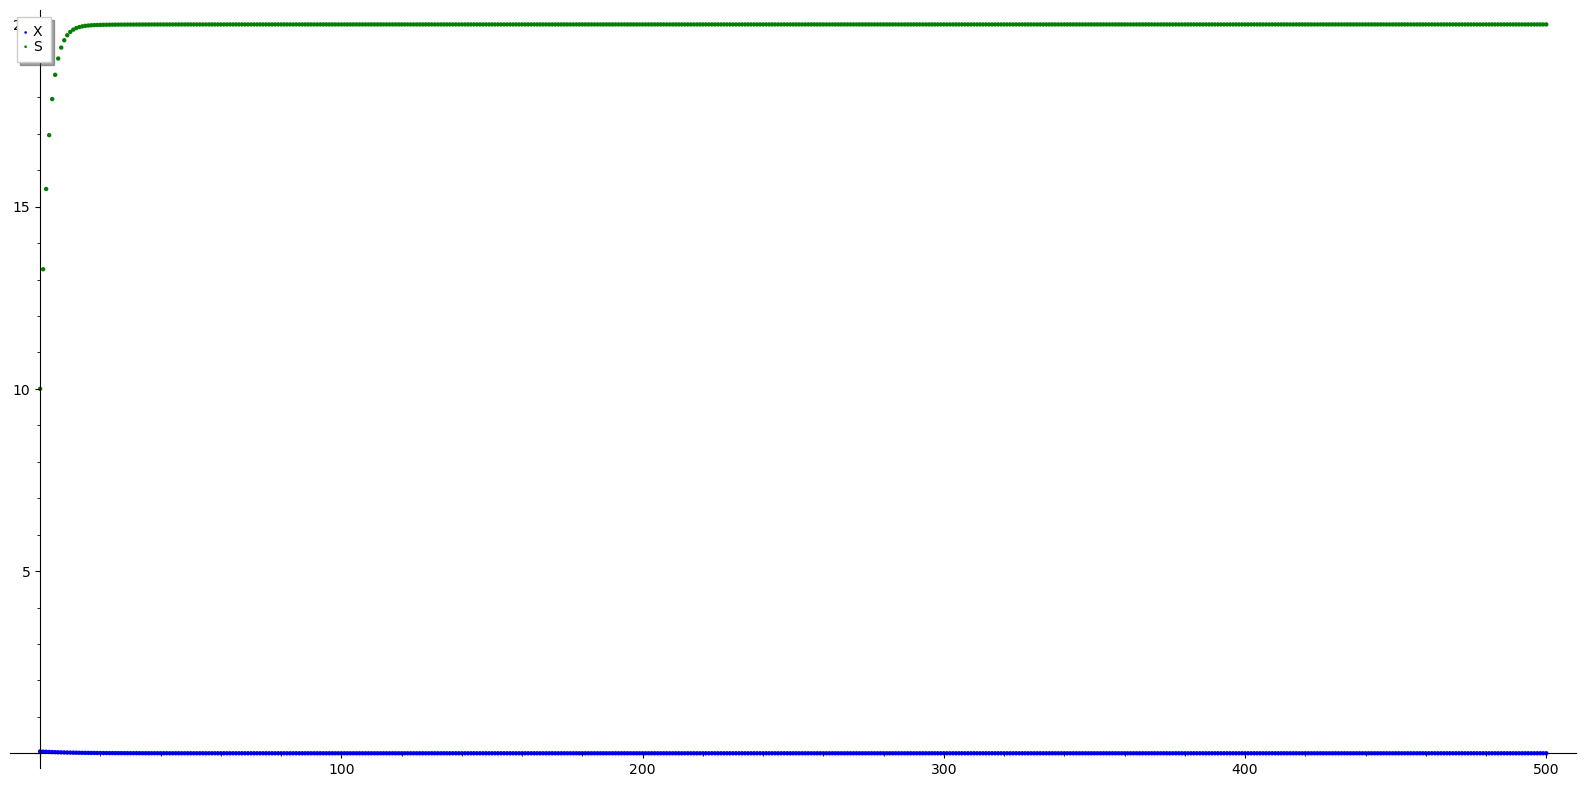

In [157]:
def plot_sol(sol):
    sim = get_sim_array(sol)
    P = list_plot(sim[:,0],legend_label='X')
    colors = ['blue','green']
    for i,var in enumerate(['S']):
        P += list_plot(sim[:,i+1],color=colors[i+1],legend_label=var)
   
    show(P, figsize=(16, 8))
plot_sol(T.solution)

In [92]:
mumax*Sf/(Ks+Sf)

1.52380952380952

In [93]:
mumax = 1.6   
Ks = 1.00     
Y = 0.8     
Sf = 20.0    
D = 1.52380952380952
#mu = mumax*S/(Ks+S)

In [94]:
T = ode_solver()
T.function = model
T.algorithm='rk8pd'
inits = [0.05, 10.0]
tspan = [0,100]
T.ode_solve(tspan, inits, num_points=500, params=[D, Sf, Y, mumax, Ks])

In [95]:
def get_sim_array(sol):
    sim = np.array([y for t,y in sol])
    return sim
get_sim_array(T.solution)

array([[ 0.05      , 10.        ],
       [ 0.04946665, 12.61125885],
       [ 0.04913744, 14.53645711],
       ...,
       [ 0.04737293, 19.94078384],
       [ 0.04737089, 19.94078639],
       [ 0.04736885, 19.94078894]])

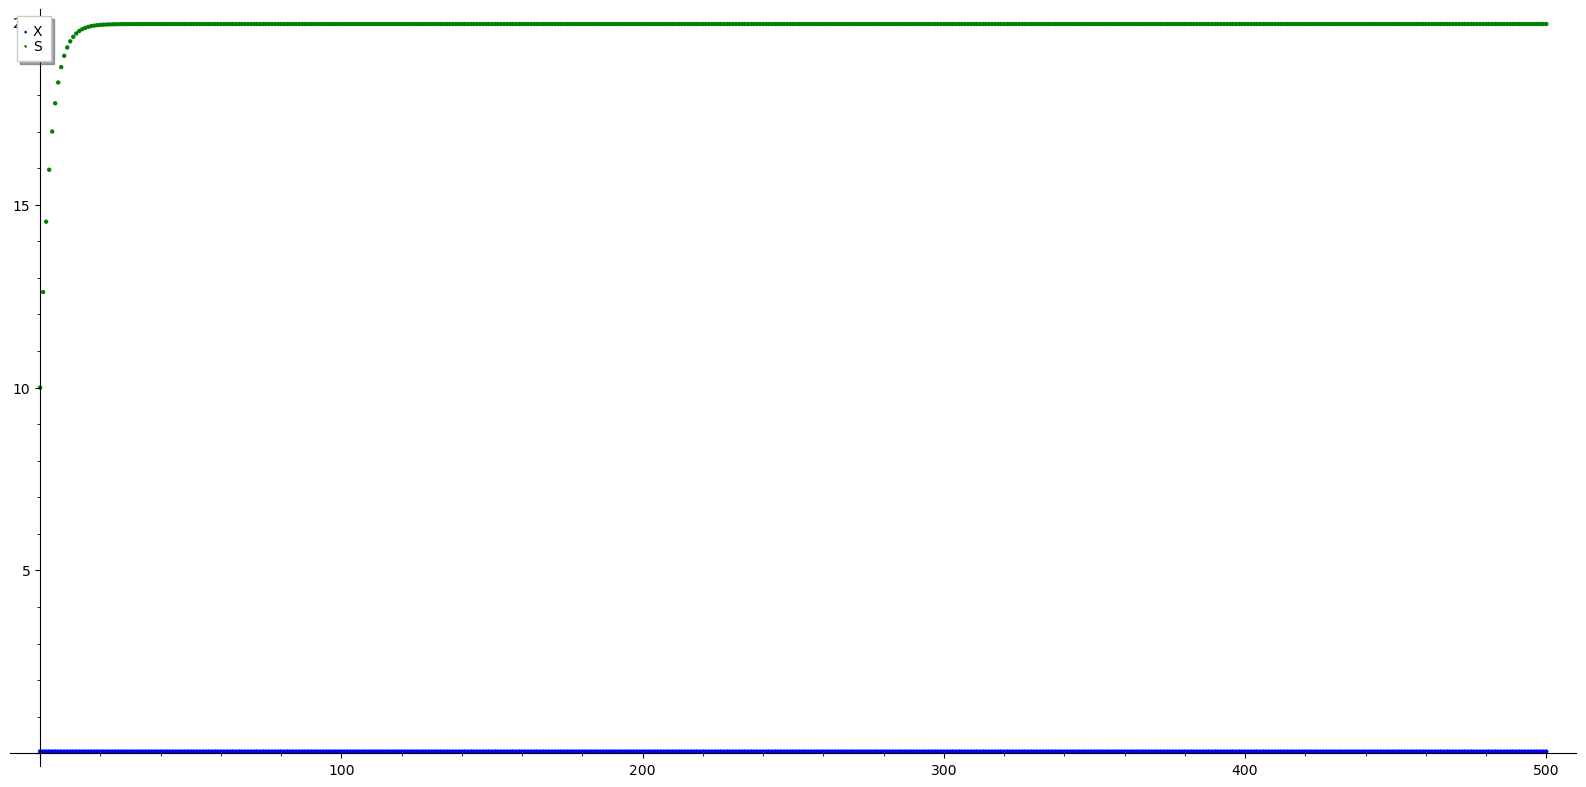

In [96]:
def plot_sol(sol):
    sim = get_sim_array(sol)
    P = list_plot(sim[:,0],legend_label='X')
    colors = ['blue','green']
    for i,var in enumerate(['S']):
        P += list_plot(sim[:,i+1],color=colors[i+1],legend_label=var)
   
    show(P, figsize=(16, 8))
plot_sol(T.solution)

In [10]:
mumax = 1.6   
Ks = 1.00     
Y = 0.8     
Sf = 20.0    
D = 1.5
#mu = mumax*S/(Ks+S)

In [11]:
S = Ks*D/(mumax-D)
print(mumax-D)
print(Ks*D)
print(S)

0.100000000000000
1.50000000000000
15.0000000000000


In [12]:
mu = mumax*S/(Ks+S)
print(mu)

1.50000000000000


In [98]:
T = ode_solver()
T.function = model
T.algorithm='rk8pd'
inits = [0.05, 10.0]
tspan = [0,100]
T.ode_solve(tspan, inits, num_points=500, params=[D, Sf, Y, mumax, Ks])

In [99]:
def get_sim_array(sol):
    sim = np.array([y for t,y in sol])
    return sim
get_sim_array(T.solution)

array([[ 0.05      , 10.        ],
       [ 0.04970085, 12.57599287],
       [ 0.0496024 , 14.48418137],
       ...,
       [ 0.47512923, 19.40608846],
       [ 0.477185  , 19.40351875],
       [ 0.47924871, 19.40093911]])

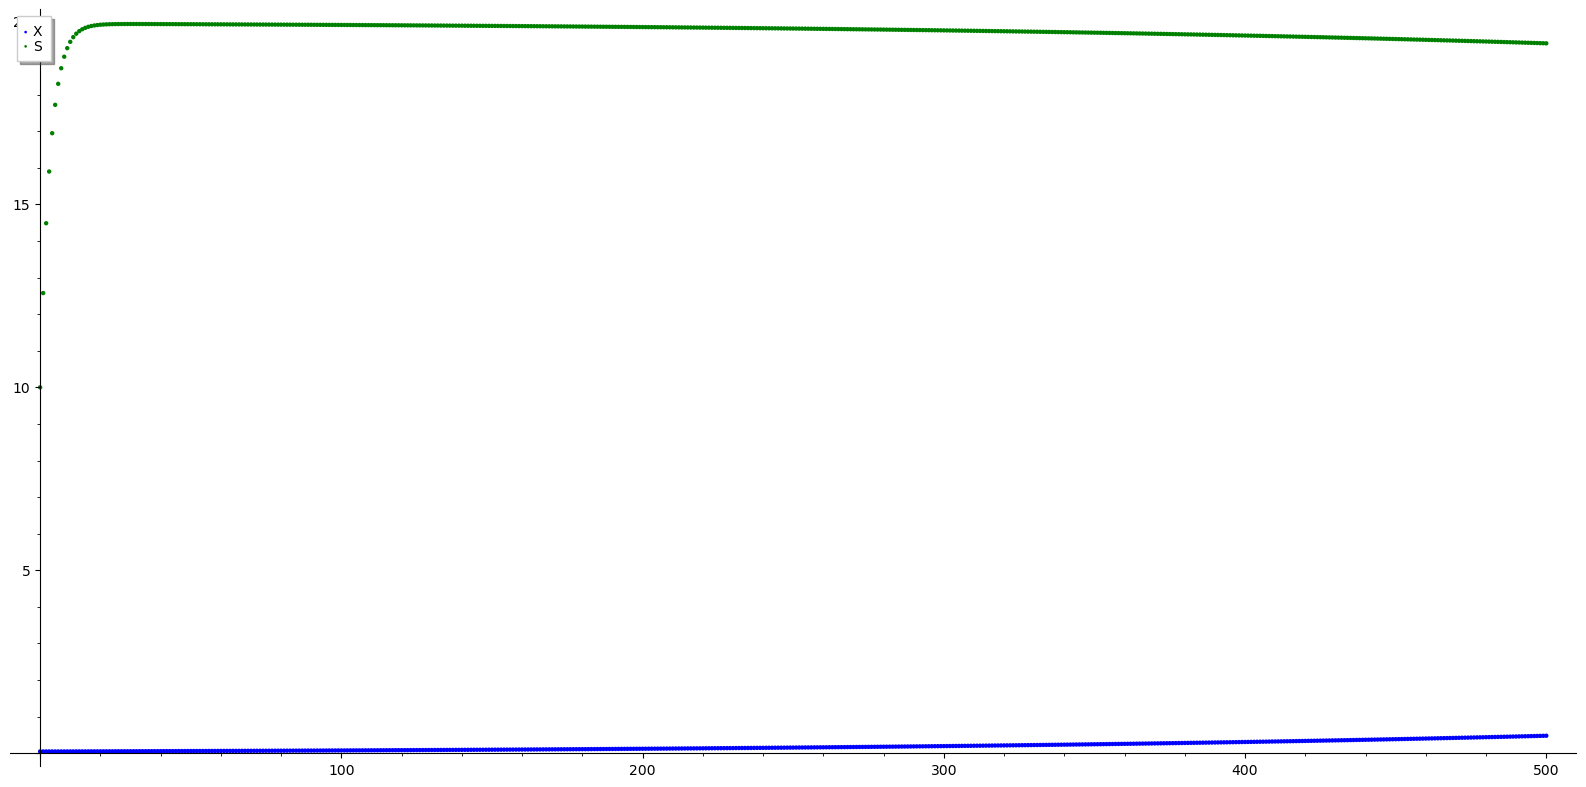

In [100]:
def plot_sol(sol):
    sim = get_sim_array(sol)
    P = list_plot(sim[:,0],legend_label='X')
    colors = ['blue','green']
    for i,var in enumerate(['S']):
        P += list_plot(sim[:,i+1],color=colors[i+1],legend_label=var)
   
    show(P, figsize=(16, 8))
plot_sol(T.solution)

Aumentando o tempo de análise do modelo:

In [17]:
T = ode_solver()
T.function = model
T.algorithm='rk8pd'
inits = [0.05, 10.0]
tspan = [0,500]
T.ode_solve(tspan, inits, num_points=500, params=[D, Sf, Y, mumax, Ks])

In [18]:
def get_sim_array(sol):
    sim = np.array([y for t,y in sol])
    return sim
get_sim_array(T.solution)

array([[ 0.05      , 10.        ],
       [ 0.04982514, 17.72036261],
       [ 0.05078575, 19.44175882],
       ...,
       [ 3.99977378, 15.00028278],
       [ 3.99978074, 15.00027408],
       [ 3.99978748, 15.00026564]])

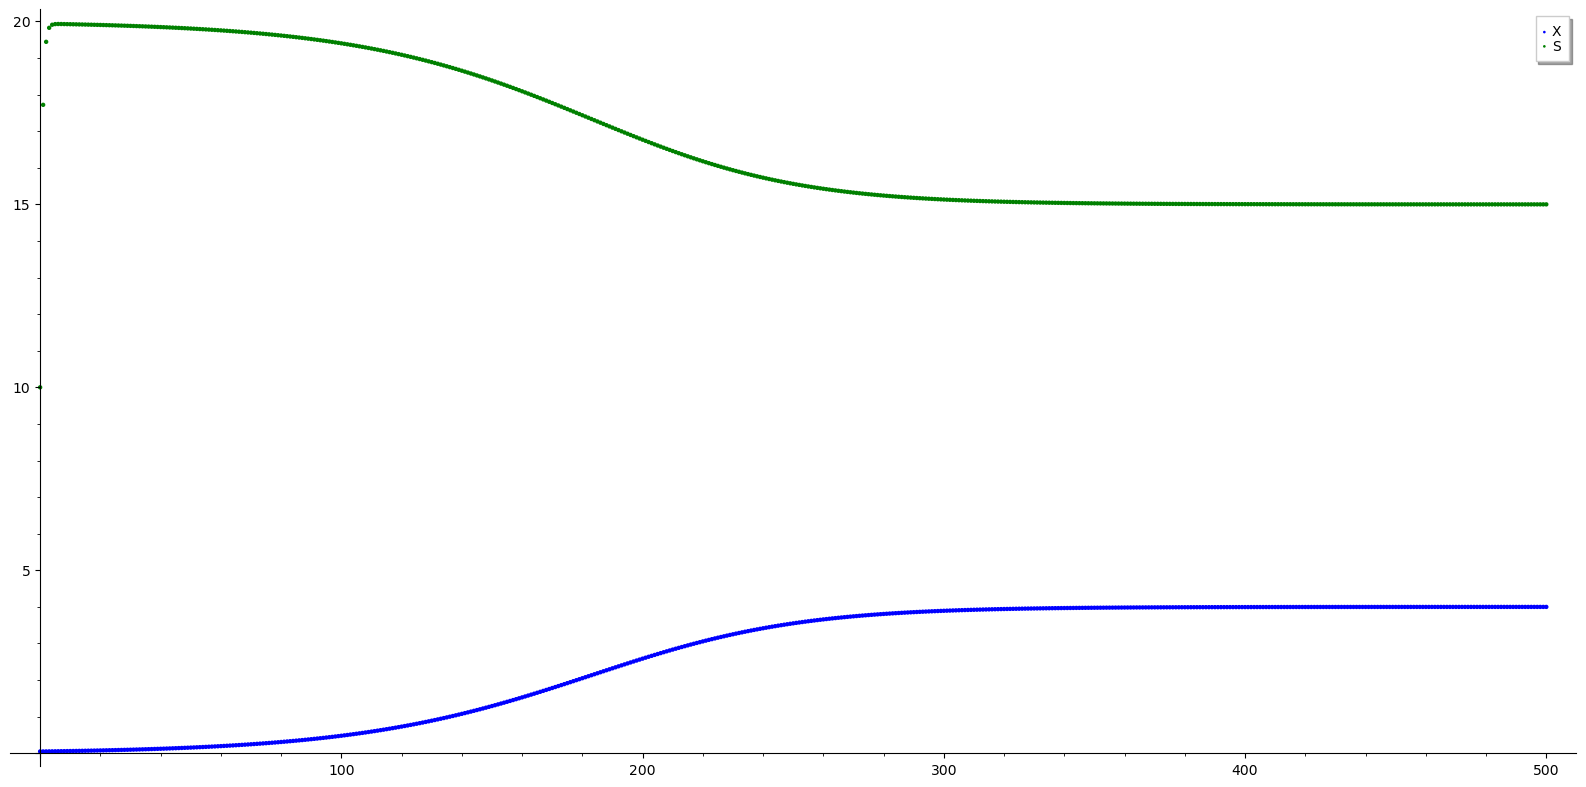

In [19]:
def plot_sol(sol):
    sim = get_sim_array(sol)
    P = list_plot(sim[:,0],legend_label='X')
    colors = ['blue','green']
    for i,var in enumerate(['S']):
        P += list_plot(sim[:,i+1],color=colors[i+1],legend_label=var)
   
    show(P, figsize=(16, 8))
plot_sol(T.solution)

Diminuindo a taxa de diluição:

In [90]:
mumax = 1.6   
Ks = 1.00     
Y = 0.8     
Sf = 20.0    
D = 0.50
#mu = mumax*S/(Ks+S)

In [91]:
S = Ks*D/(mumax-D)
print(mumax-D)
print(Ks*D)
print(S)

1.10000000000000
0.500000000000000
0.454545454545455


In [92]:
X = Y*(Sf- (Ks*D/(mumax-D)))
print(X)

15.6363636363636


In [93]:
mu = mumax*S/(Ks+S)
print(mu)

0.500000000000000


In [162]:
T = ode_solver()
T.function = model
T.algorithm='rk8pd'
inits = [0.05, 10.0]
tspan = [0,100]
T.ode_solve(tspan, inits, num_points=500, params=[D, Sf, Y, mumax, Ks])

In [163]:
def get_sim_array(sol):
    sim = np.array([y for t,y in sol])
    return sim
get_sim_array(T.solution)

array([[ 0.05      , 10.        ],
       [ 0.06058936, 10.93244146],
       [ 0.07356861, 11.77190238],
       ...,
       [15.63636364,  0.45454545],
       [15.63636364,  0.45454545],
       [15.63636364,  0.45454545]])

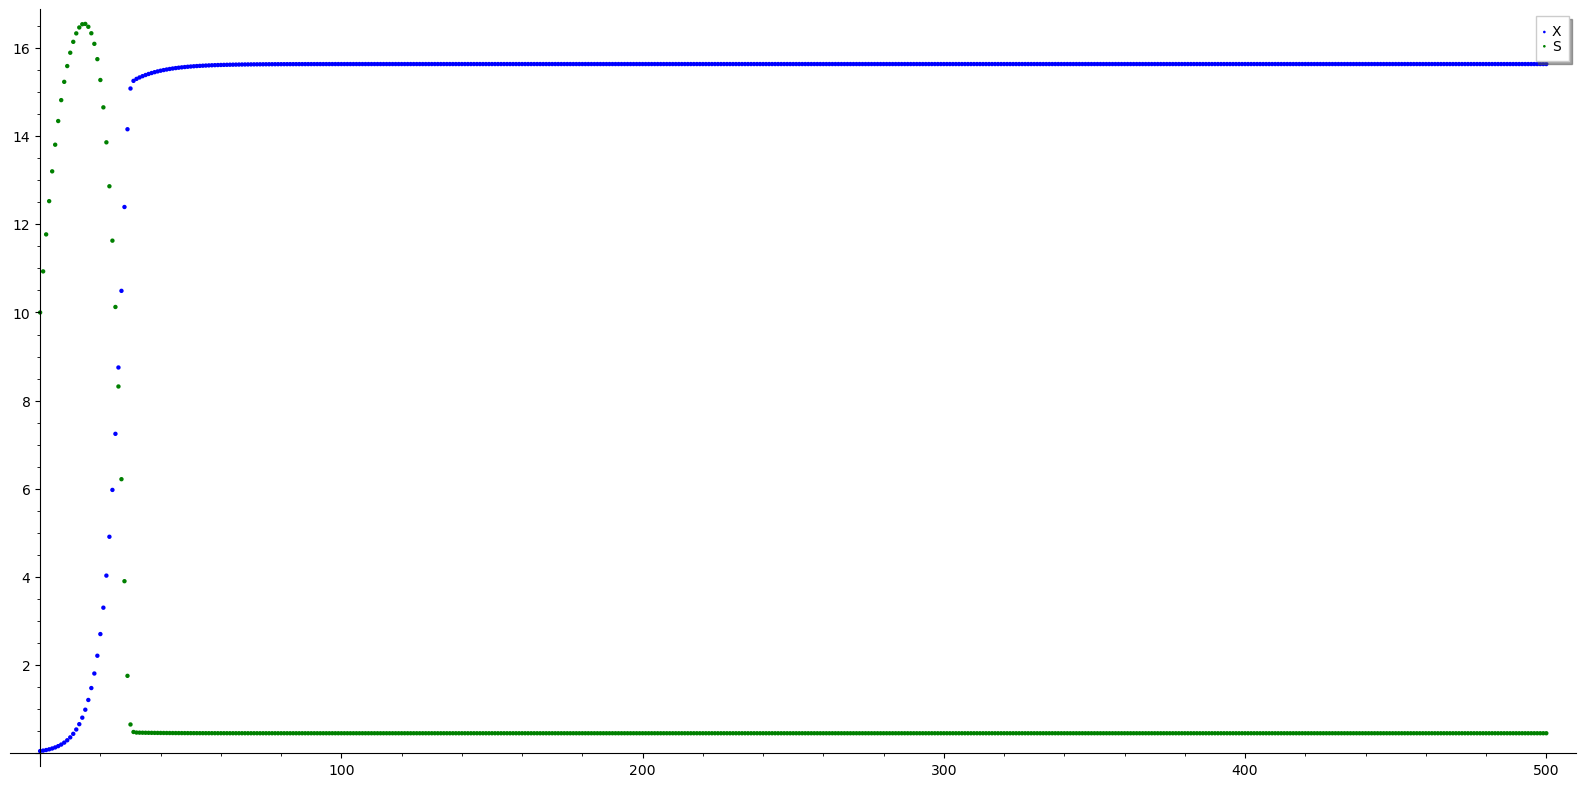

In [164]:
def plot_sol(sol):
    sim = get_sim_array(sol)
    P = list_plot(sim[:,0],legend_label='X')
    colors = ['blue','green']
    for i,var in enumerate(['S']):
        P += list_plot(sim[:,i+1],color=colors[i+1],legend_label=var)
   
    show(P, figsize=(16, 8))
plot_sol(T.solution)

Dobrando a constante de saturação:

In [69]:
mumax = 1.6   
Ks = 2.00     
Y = 0.8     
Sf = 20.0    
D = 1.00
#mu = mumax*S/(Ks+S)

In [70]:
S = Ks*D/(mumax-D)
print(S)

3.33333333333333


In [71]:
mu = mumax*S/(Ks+S)
print(mu)

1.00000000000000


In [24]:
T = ode_solver()
T.function = model
T.algorithm='rk8pd'
inits = [0.05, 10.0]
tspan = [0,100]
T.ode_solve(tspan, inits, num_points=500, params=[D, Sf, Y, mumax, Ks])

In [25]:
def get_sim_array(sol):
    sim = np.array([y for t,y in sol])
    return sim
get_sim_array(T.solution)

array([[ 0.05      , 10.        ],
       [ 0.05364776, 11.79680344],
       [ 0.05788364, 13.26633999],
       ...,
       [13.33333333,  3.33333333],
       [13.33333333,  3.33333333],
       [13.33333333,  3.33333333]])

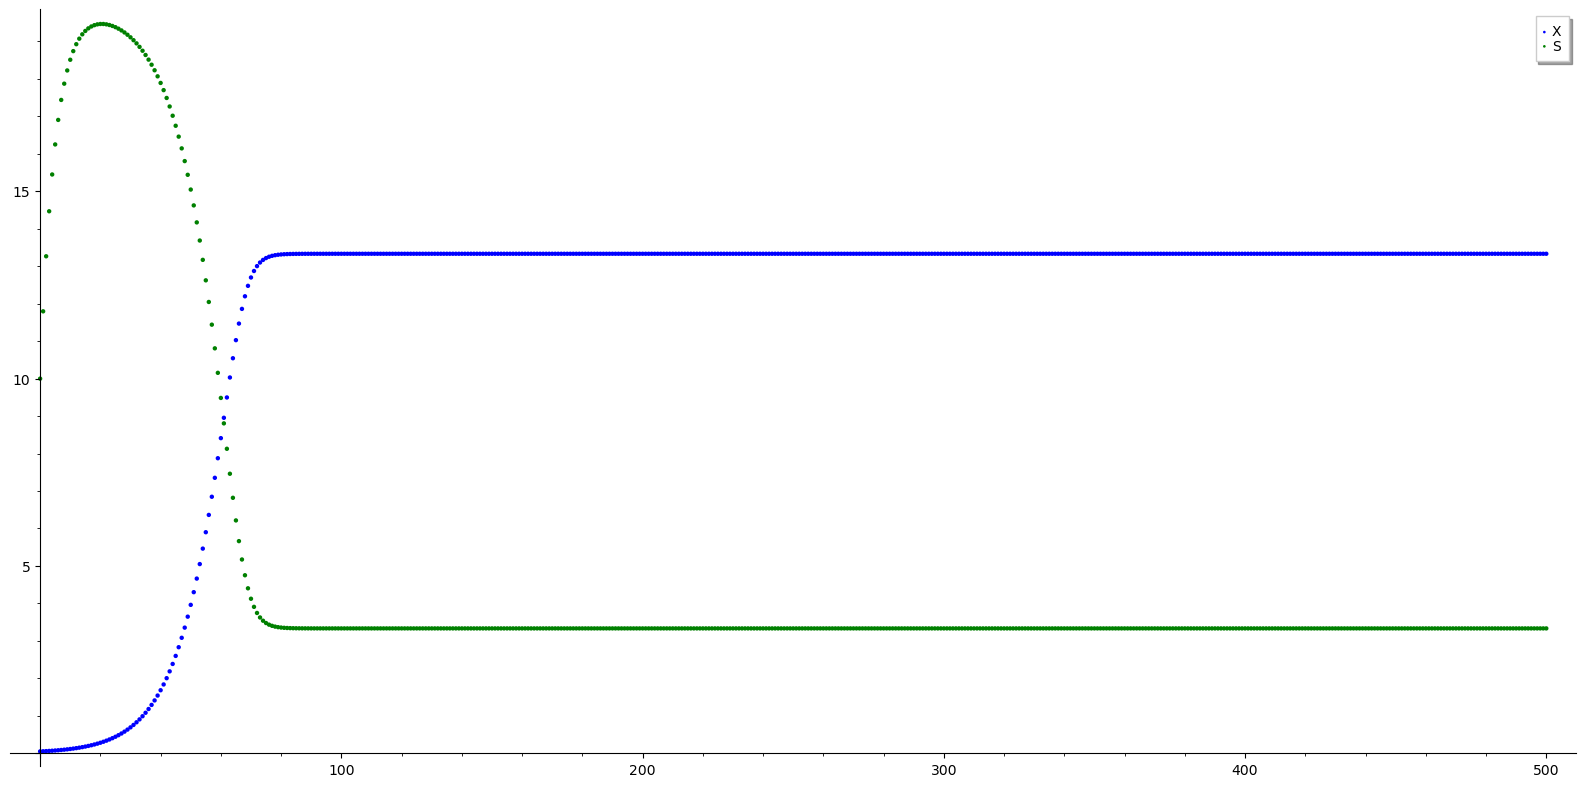

In [26]:
def plot_sol(sol):
    sim = get_sim_array(sol)
    P = list_plot(sim[:,0],legend_label='X')
    colors = ['blue','green']
    for i,var in enumerate(['S']):
        P += list_plot(sim[:,i+1],color=colors[i+1],legend_label=var)
   
    show(P, figsize=(16, 8))
plot_sol(T.solution)

Diminuindo a constante de saturação pela metade:

In [72]:
mumax = 1.6   
Ks = 0.5
Y = 0.8     
Sf = 20.0    
D = 1.00
#mu = mumax*S/(Ks+S)

In [73]:
S = Ks*D/(mumax-D)
print(S)

0.833333333333333


In [74]:
mu = mumax*S/(Ks+S)
print(mu)

1.00000000000000


In [32]:
T = ode_solver()
T.function = model
T.algorithm='rk8pd'
inits = [0.05, 10.0]
tspan = [0,100]
T.ode_solve(tspan, inits, num_points=500, params=[D, Sf, Y, mumax, Ks])

In [33]:
def get_sim_array(sol):
    sim = np.array([y for t,y in sol])
    return sim
get_sim_array(T.solution)

array([[ 0.05      , 10.        ],
       [ 0.0555894 , 11.7943764 ],
       [ 0.06191245, 13.26130398],
       ...,
       [15.33333333,  0.83333333],
       [15.33333333,  0.83333333],
       [15.33333333,  0.83333333]])

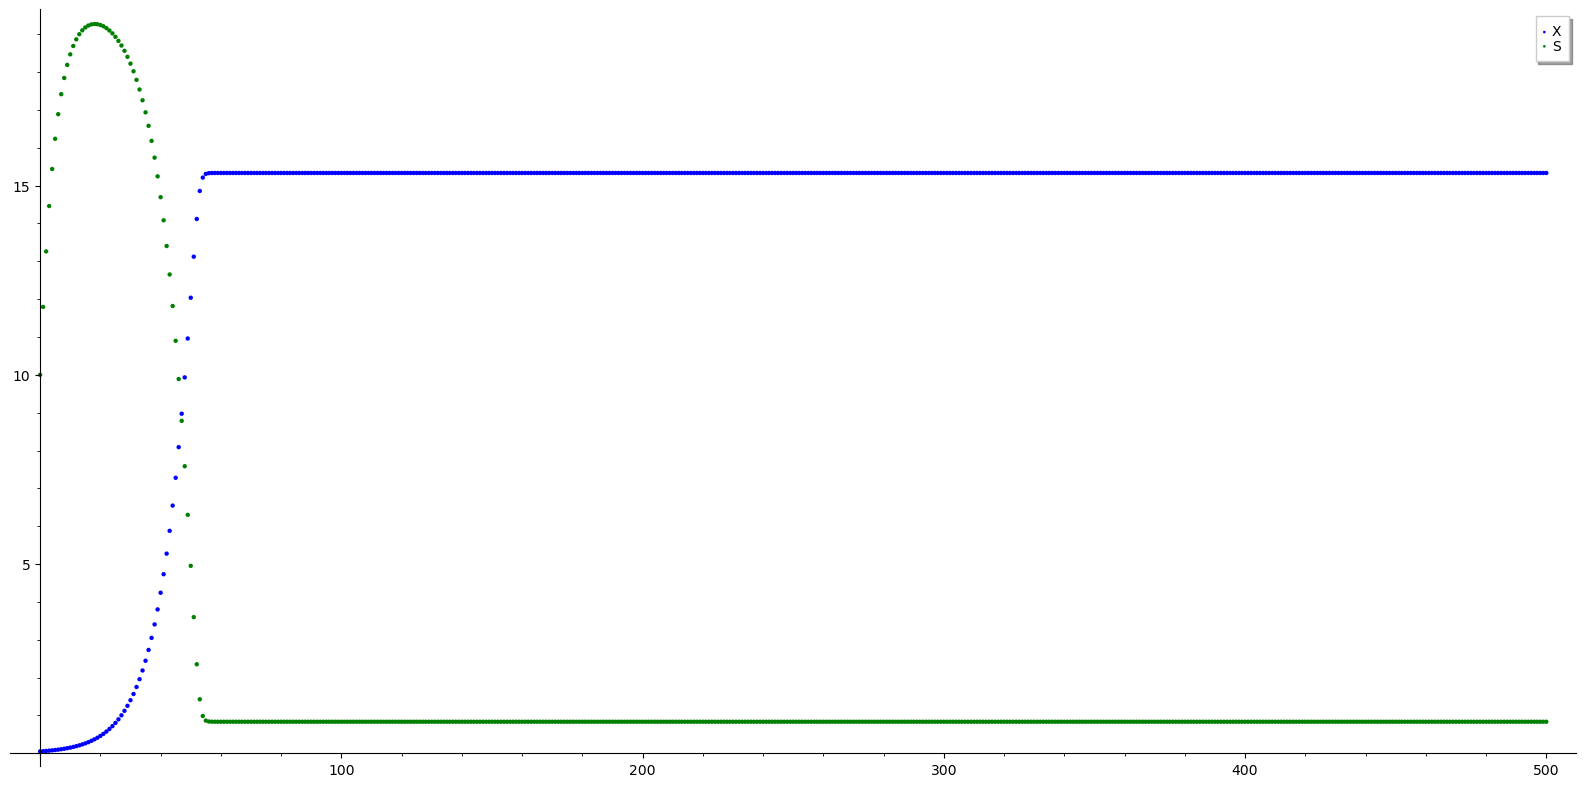

In [34]:
def plot_sol(sol):
    sim = get_sim_array(sol)
    P = list_plot(sim[:,0],legend_label='X')
    colors = ['blue','green']
    for i,var in enumerate(['S']):
        P += list_plot(sim[:,i+1],color=colors[i+1],legend_label=var)
   
    show(P, figsize=(16, 8))
plot_sol(T.solution)

Dobrando o limite de concentração de entrada do substrato:

In [75]:
mumax = 1.6   
Ks = 1.0
Y = 0.8     
Sf = 40.0    
D = 1.00
#mu = mumax*S/(Ks+S)

In [76]:
S = Ks*D/(mumax-D)
print(S)

1.66666666666667


In [77]:
mu = mumax*S/(Ks+S)
print(mu)

1.00000000000000


In [144]:
T = ode_solver()
T.function = model
T.algorithm='rk8pd'
inits = [0.05, 10.0]
tspan = [0,100]
T.ode_solve(tspan, inits, num_points=500, params=[D, Sf, Y, mumax, Ks])

In [145]:
def get_sim_array(sol):
    sim = np.array([y for t,y in sol])
    return sim
get_sim_array(T.solution)

array([[ 0.05      , 10.        ],
       [ 0.05506577, 15.42041587],
       [ 0.06102882, 19.8560076 ],
       ...,
       [30.66666667,  1.66666667],
       [30.66666667,  1.66666667],
       [30.66666667,  1.66666667]])

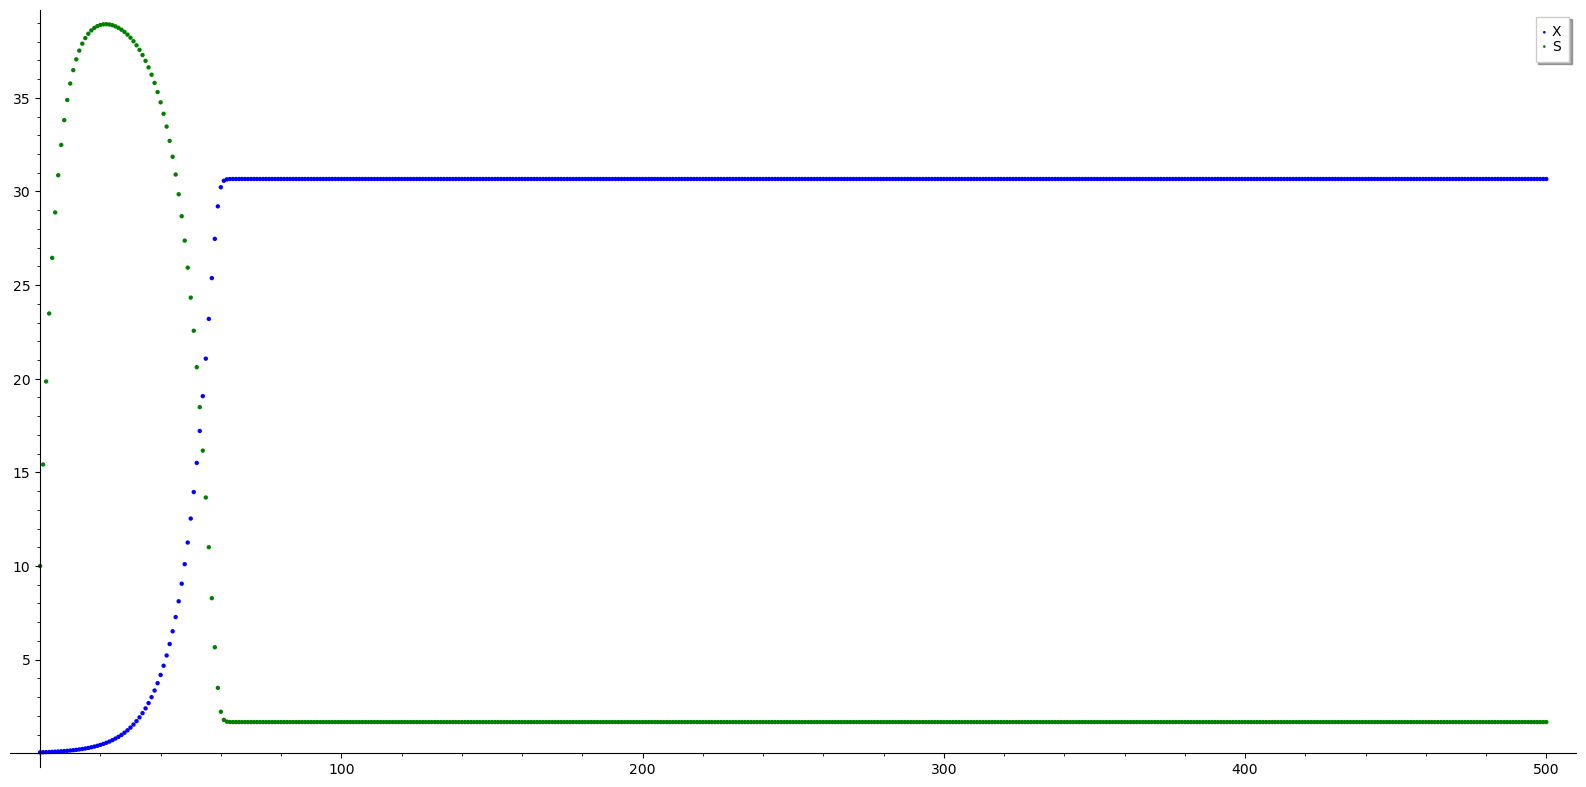

In [146]:
def plot_sol(sol):
    sim = get_sim_array(sol)
    P = list_plot(sim[:,0],legend_label='X')
    colors = ['blue','green']
    for i,var in enumerate(['S']):
        P += list_plot(sim[:,i+1],color=colors[i+1],legend_label=var)
   
    show(P, figsize=(16, 8))
plot_sol(T.solution)

Diminuindo o limite de concentração de entrada do substrato pela metade:

In [78]:
mumax = 1.6   
Ks = 1.0
Y = 0.8     
Sf = 10.0    
D = 1.00
#mu = mumax*S/(Ks+S)

In [79]:
S = Ks*D/(mumax-D)
print(S)

1.66666666666667


In [80]:
mu = mumax*S/(Ks+S)
print(mu)

1.00000000000000


In [148]:
T = ode_solver()
T.function = model
T.algorithm='rk8pd'
inits = [0.05, 10.0]
tspan = [0,100]
T.ode_solve(tspan, inits, num_points=500, params=[D, Sf, Y, mumax, Ks])

In [149]:
def get_sim_array(sol):
    sim = np.array([y for t,y in sol])
    return sim
get_sim_array(T.solution)

array([[ 0.05      , 10.        ],
       [ 0.0547572 ,  9.98272417],
       [ 0.05996439,  9.96693951],
       ...,
       [ 6.66666667,  1.66666667],
       [ 6.66666667,  1.66666667],
       [ 6.66666667,  1.66666667]])

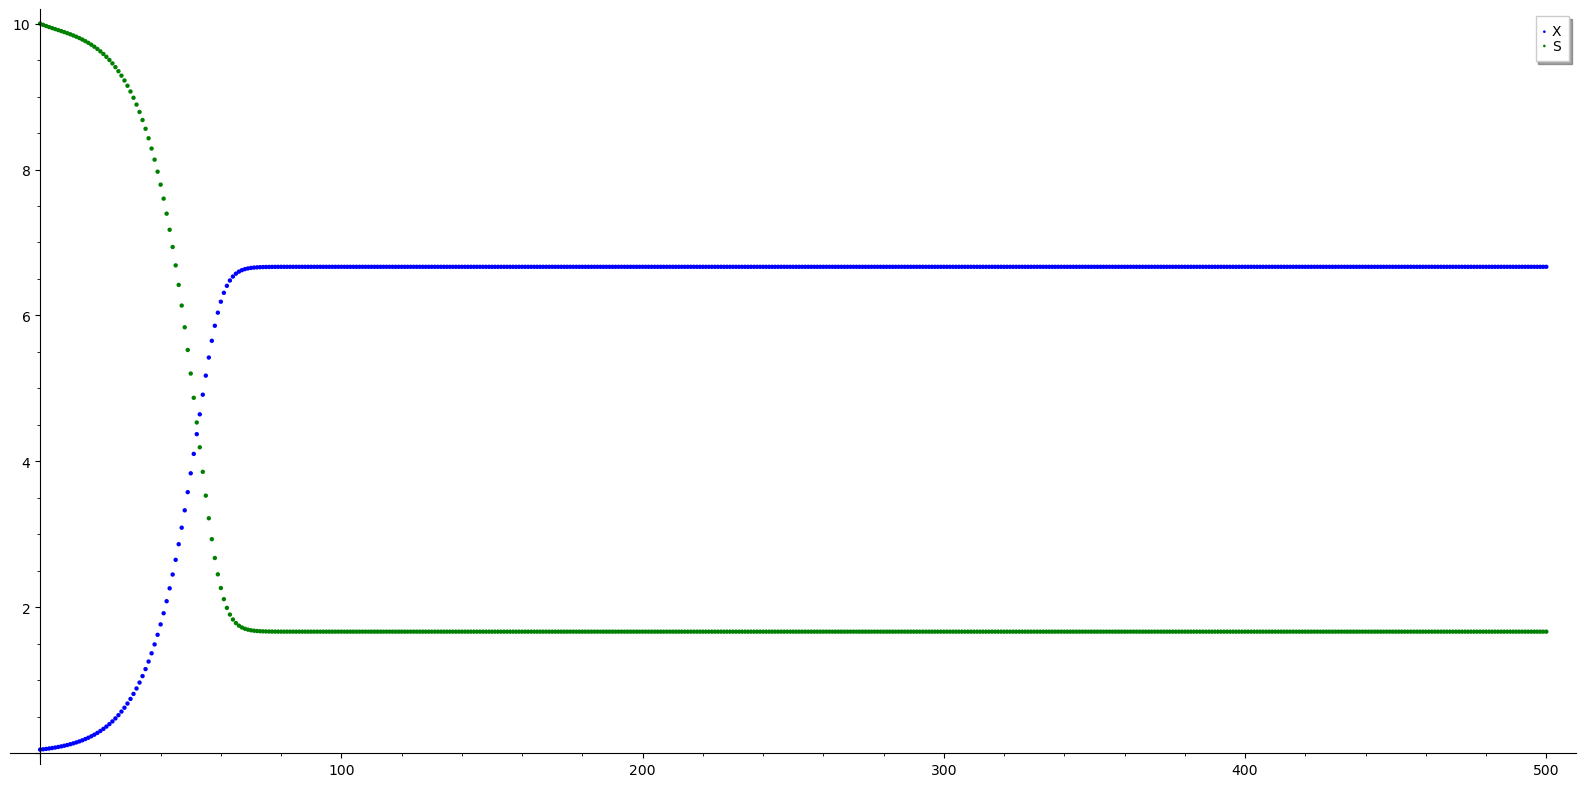

In [150]:
def plot_sol(sol):
    sim = get_sim_array(sol)
    P = list_plot(sim[:,0],legend_label='X')
    colors = ['blue','green']
    for i,var in enumerate(['S']):
        P += list_plot(sim[:,i+1],color=colors[i+1],legend_label=var)
   
    show(P, figsize=(16, 8))
plot_sol(T.solution)

Modelando como na Aula 1:

In [53]:
def ODEsys(t,y,params):
    mumax, Ks, D, Y, Sf = params
    X,S = y
    return[(mumax*S/(Ks+S))*X - D*X, #dX/dt
        D*Sf - D*S -((mumax*S/(Ks+S))*X/Y) # dS/dt
          ]

In [54]:
T=ode_solver()
T.algorithm="rk8pd"
T.function=ODEsys
T.ode_solve(y_0=[0.5,10.0],t_span=[0,50],params=[1.6, 1.0, 1.0, 0.8, 20.0],num_points=200)

In [55]:
T.solution[:10]

[(0, [0.500000000000000, 10.0000000000000]),
 (0.25, [0.5618952721750273, 11.996373568486797]),
 (0.5, [0.6341506672754752, 13.52108673109972]),
 (0.75, [0.7175394213438134, 14.674639291373325]),
 (1.0, [0.813233180643823, 15.53458876321311]),
 (1.25, [0.9226937863419092, 16.160650296508518]),
 (1.5, [1.0476442742552134, 16.59859940578965]),
 (1.75, [1.1900693446026933, 16.8832825993989]),
 (2.0, [1.352228995847822, 17.040945474847156]),
 (2.25, [1.5366787748013386, 17.09103380123101])]

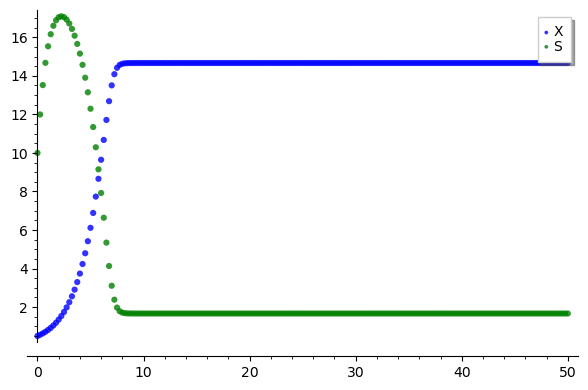

In [56]:
x=list_plot([(i[0],i[1][0]) for i in T.solution],color='blue', pointsize=20, legend_label='X', alpha=.8)
s=list_plot([(i[0],i[1][1]) for i in T.solution],color='green', pointsize=20, legend_label='S', alpha=.8)
x.legend()
s.legend()
show(x+s)

In [4]:
mumax = 1.6   
Ks = 3.00     
Y = 0.8     
Sf = 20.0    
D = 1.00
#mu = mumax*S/(Ks+S)

In [5]:
S = Ks*D/(mumax-D)
print(S)

5.00000000000000


In [6]:
mu = mumax*S/(Ks+S)
print(mu)

1.00000000000000
